$\newcommand{\defeq}{=}$
$\newcommand{\card}[1]{|#1|}$


In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
import random
from itertools import chain, combinations
from collections import OrderedDict
from time import time

import numpy as np
from scipy import sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from IPython.display import display, Math


import pandas as pd

In [3]:
%matplotlib widget


matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams.update({"legend.fontsize": 7})
matplotlib.rcParams.update({"font.size": 7})

# Basic Functions

In [4]:
def plot_sets_on_ax(W, S, K=None, T=None, ax=None, marker=".", **kwargs):
    if ax is None:
        ax = plt.gca()

    if K is not None:
        K_idx = np.where(K)[0]
        Kbar_idx = np.where(~S & ~K)[0]
        ax.scatter(K_idx, W[K], c="y", label=r"$K$", marker=marker, **kwargs)
        ax.scatter(Kbar_idx, W[~K & ~S], c="b", label=r"$(\Omega \backslash S) \backslash K$", marker=marker, **kwargs)
    
    if T is not None:
        T_idx = np.where(T)[0]
        Tbar_idx = np.where(S & ~T)[0]
        ax.scatter(T_idx, W[T], c="r", label=r"$T$", marker=marker, **kwargs)
        ax.scatter(Tbar_idx, W[~T & S], c="g", label=r"$S \backslash T$", marker=marker, **kwargs)

def plot_ini_on_ax(W, S, ax=None, marker=".", **kwargs):
    if ax is None:
        ax = plt.gca()
    S_idx = np.where(S)[0]
    Sbar_idx = np.where(~S)[0]
    ax.scatter(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b", marker=".");
    ax.scatter(S_idx, W[S], label="W[S]", c="g", marker=".");

def powerset(iterable):
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    # return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

class MultiPlot:

    def __init__(self, nrow, ncol, *args, **kwargs):
        self.nrow = nrow
        self.ncol = ncol
        self.fig = plt.figure(*args, **kwargs)
    
    def add_subplot(self, pos, nrow=None, ncol=None, *args, **kwargs):
        if nrow is None:
            nrow = self.nrow
        if ncol is None:
            ncol = self.ncol
        if isinstance(pos, tuple):
            pos = (pos[0] - 1) * self.ncol + pos[1]
        return self.fig.add_subplot(nrow, ncol, pos, *args, **kwargs)

# Weights definition

In [104]:
from importlib import import_module
# from deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models import GenericLightningModel
models_old = import_module("deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models.lightning_bimonn")
LightningBiMoNNClassifierLastLinearNotBinary = models_old.LightningBiMoNNClassifierLastLinearNotBinary

weights_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_77/bimonn_last_linear/7/mnistclassifchannel/bimonnclassifierlastlinearnotbinary/version_0/best_weights/epoch=26-step=21113.ckpt"
model = LightningBiMoNNClassifierLastLinearNotBinary.load_from_checkpoint(weights_path)

Ws = model.model.layers[-1].bises.weight.detach().cpu().numpy()
bs = -model.model.layers[-1].bises.bias.detach().cpu().numpy()
Ws = Ws.reshape(Ws.shape[0], np.prod(Ws.shape[1:]))


{'bise_init_method': <InitBiseEnum.CUSTOM_CONSTANT_RANDOM_BIAS: 6>, 'lui_init_method': <InitBiseEnum.CUSTOM_CONSTANT_CONSTANT_WEIGHTS_RANDOM_BIAS: 14>, 'bise_init_args': {'ub': 0.01, 'max_output_value': 0.95, 'p_for_init': 'auto'}, 'input_mean': 0.10320870578289032}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

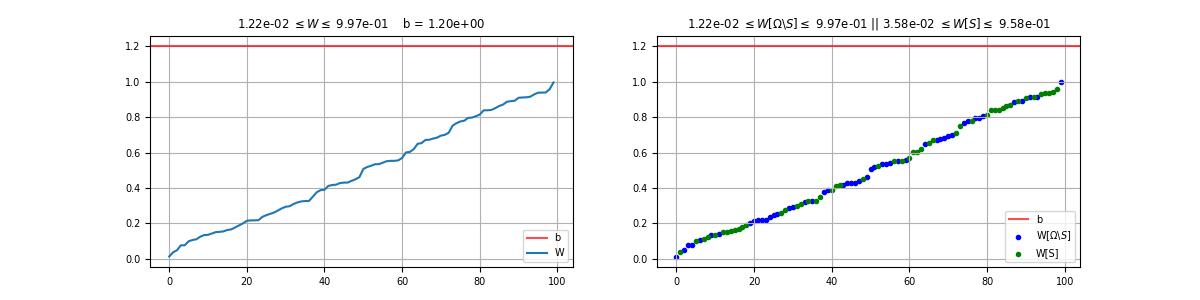

In [105]:
####### Weights initialization #######

# W = np.load("weights.npy")
# b = np.load("bias.npy")
# chout = 316
# W = np.unique(Ws[chout])
# W = Ws[chout]
# b = bs[chout]
W = np.unique(np.random.rand(100))
b = 1.2

N = len(W)
omega = np.ones_like(W).astype(bool)
epsilon = 1e-4  # for numerical stability

idx_S = len(W) // 2
thresh = W[idx_S]
# S = W >= thresh
S = np.zeros(N, dtype=bool)
S[random.sample(range(N), N // 2)] = True
S_idx = np.where(S)[0]
Sbar_idx = np.where(~S)[0]

####### Prints #######

def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
    lb = Wini[~S].sum()
    return lb  <= bini * (1 + epsilon)  # Small relaxation for numerical errors
    
def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
    ub = Wini[S].min()
    return ub >= bini * (1 - epsilon)  # Small relaxation for numerical errors

display(Math(r"\sum_{k \in \Omega \backslash S}w_k \leq b: " + f"{left_cond(Wini=W, bini=b, S=S)}"),)
display(Math(r"b \leq \min_{s \in S}w_s: " + f"{right_cond(Wini=W, bini=b, S=S)}"),)

fig = plt.figure(figsize=(6*2, 3))
ax = fig.add_subplot(121)
ax.axhline(y=b, c="r", label="b", alpha=.7)
ax.plot(W, label="W");
ax.set_title(fr"{W.min():.2e} $\leq W \leq$ {W.max():.2e}    b = {b:.2e}")
ax.legend();

ax = fig.add_subplot(122)
ax.axhline(y=b, c="r", label="b", alpha=.7)
# ax.plot(S_idx, W[S], label="W[S]", c="g");
# ax.plot(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b");
ax.scatter(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b", marker=".");
ax.scatter(S_idx, W[S], label="W[S]", c="g", marker=".");
ax.set_title(fr"{W[~S].min():.2e} $\leq W[\Omega \backslash S] \leq$ {W[~S].max():.2e} || {W[S].min():.2e} $\leq W[S] \leq$ {W[S].max():.2e}")
# ax.axvline(x=idx_S, c="g", label="threshold", alpha=.7, ls="--")
ax.legend();

plt.show();


# Matrix Computation

In [5]:
def system(Kbar, K, T):
    A = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))
    
    A[:Kbar, :Kbar] = np.eye(Kbar)
    A[:Kbar, Kbar] = 1
    
    A[Kbar:Kbar+K, Kbar] = 1
    A[Kbar:Kbar+K, Kbar+1:Kbar+1+K] = -np.eye(K)

    A[Kbar+K: Kbar+K+T, Kbar+K+1:Kbar+K+T+1] = -np.eye(T)
    A[Kbar+K: Kbar+K+T, -1] = 1

    A[-2, Kbar] = -1
    A[-2, -(T+1):] = 1

    A[-1, :Kbar] = 1
    A[-1, -1] = -1

    return A

def system_inv(Kbar, K, T):
    Ainv = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))

    c = 1 / (Kbar * (T + 1) + 1)
    a = (T + 1) * c
    d = Kbar * c


    Ainv[:Kbar, :Kbar] = np.eye(Kbar) - a
    Ainv[:Kbar, Kbar + K:-1] = c
    Ainv[:Kbar, -1] = a

    Ainv[Kbar, :Kbar] = a
    Ainv[Kbar, Kbar + K:-1] = -c
    Ainv[Kbar, -1] = -a

    Ainv[Kbar+1:Kbar+K+1, :Kbar] = a
    Ainv[Kbar+1:Kbar+K+1, Kbar: Kbar + K] = -np.eye(K)
    Ainv[Kbar+1:Kbar+K+1, Kbar + K:-1] = -c
    Ainv[Kbar+1:Kbar+K+1, -1] = -a

    Ainv[Kbar+K+1:-1, :Kbar] = c
    Ainv[Kbar+K+1:-1, Kbar + K:-2] = d - np.eye(T)
    Ainv[Kbar+K+1:-1, -2] = d
    Ainv[Kbar+K+1:-1, -1] = -c

    Ainv[-1, :Kbar] = c
    Ainv[-1, Kbar + K:-1] = d
    Ainv[-1, -1] = -c

    return Ainv

In [4]:
Kbar, K, T = 13, 4, 10
A = system(Kbar, K, T)
# display(A)
Ainv = np.linalg.inv(A)
Ainv2 = system_inv(Kbar, K, T)
# print(np.array_str((Ainv), precision=2, suppress_small=True))
# print(np.array_str((Ainv2), precision=2, suppress_small=True))
print(np.allclose(Ainv, Ainv2))
print(np.allclose(Ainv @ A, np.eye(A.shape[0])))


True
True


In [5]:
a = Ainv[0, -1]
c = Ainv[-1, 0]
d = Ainv[-1, -2]

X = np.array([a, c, d])

#
u = np.array([
  #  a     c    d
    [Kbar, 1,   0],
    [0, Kbar,  -1],
    [0,    1, T+1]
])

u @ X

array([1.00000000e+00, 1.38777878e-17, 1.00000000e+00])

In [6]:
print("c")
print(c)
print(1 / (Kbar*(T+1) + 1))

print("d")
print(d)
print(Kbar / (Kbar*(T+1) + 1))

print("a")
print(a)
print((T+1) / (Kbar*(T+1) + 1))

c
0.006944444444444445
0.006944444444444444
d
0.09027777777777778
0.09027777777777778
a
0.0763888888888889
0.0763888888888889


# Iterative Weights and Bias

In [83]:
from dataclasses import dataclass

@dataclass
class IterativeProjection:
    Wini: np.ndarray
    bini: float
    S: np.ndarray
    operation: str = "dilation"

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        self.Wvar = cp.Variable(self.Wini.shape)
        self.bvar = cp.Variable(1)

        if self.operation == "dilation":
            self.constraints = self.dilation_constraints(self.Wvar, self.bvar, self.S)
        elif self.operation == "erosion":
            self.constraints = self.erosion_constraints(self.Wvar, self.bvar, self.S)
        else:
            raise ValueError("operation must be dilation or erosion")

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - self.Wini) + 1/2 * cp.sum_squares(self.bvar - self.bini))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()

        return self

    def dilation_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
        self.constraint0 = [cp.sum(Wvar[~S]) <= bvar]
        self.constraintsT = [bvar <= Wvar[S]]
        self.constraintsK = [Wvar >= 0]
        return self.constraint0 + self.constraintsT + self.constraintsK

    def erosion_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
        self.constraint0 = [cp.sum(Wvar[S]) >= bvar]
        self.constraintsT = [cp.sum(Wvar) - Wvar[S] <= bvar]
        self.constraintsK = [Wvar >= 0]
        return self.constraint0 + self.constraintsT + self.constraintsK

    @property
    def value(self):
        return self.prob.value

    @property
    def W(self):
        return self.Wvar.value
    
    @property
    def b(self):
        return self.bvar.value

    @property
    def K(self):
        return np.isclose(self.W, 0) & ~self.S

    @property
    def Kbar(self):
        return ~self.S & ~self.K
    
    @property
    def T(self):
        return np.isclose(self.W, self.b) & self.S

    @property
    def lambda0(self):
        return self.constraint0[0].dual_value
    
    @property
    def lambdat(self):
        return np.array([constraint.dual_value for constraint in self.constraintsT])
    
    @property
    def lambdak(self):
        return np.array([constraint.dual_value for constraint in self.constraintsK])

    @property
    def loss(self):
        return self.prob.value
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"Loss={self.loss:.4e} "
            f"Kbar: {self.Kbar.sum()} K: {self.K.sum()} T: {self.T.sum()}"
            ")"
        )




In [84]:
@dataclass
class MultiIterativeProjection:
    Wini: np.ndarray
    bini: float
    S: np.ndarray
    operation: str = "dilation"

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        # self.Wvar = cp.Variable(self.N)
        self.Wvar = cp.Variable(self.Wini.shape)
        self.bvar = cp.Variable(self.bini.shape)

        # self.constraint0 = [cp.sum(self.Wvar[~self.S]) <= self.bvar]
        # self.constraintsT = [self.bvar <= self.Wvar[self.S]]
        # self.constraintsK = [self.Wvar >= 0]

        # self.constraints = self.constraint0 + self.constraintsT + self.constraintsK
        if self.operation == "dilation":
            self.constraints = self.dilation_constraints(self.Wvar, self.bvar, self.S)
        elif self.operation == "erosion":
            self.constraints = self.erosion_constraints(self.Wvar, self.bvar, self.S)
        else:
            raise ValueError("operation must be dilation or erosion")

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - self.Wini) + 1/2 * cp.sum_squares(self.bvar - self.bini))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()
        self.loss = 1/2 * (((self.W - self.Wini)**2).sum(1) + ((self.b - self.bini)**2))

        return self

    def dilation_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
        self.constraint0 = [cp.sum(Wvar[:, ~S], axis=1) <= bvar]
        self.constraintsT = [bvar <= cp.min(Wvar[:, S], axis=1)]
        self.constraintsK = [Wvar >= 0]
        return self.constraint0 + self.constraintsT + self.constraintsK

    # def erosion_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
    #     self.constraint0 = [cp.sum(Wvar[S]) >= bvar]
    #     self.constraintsT = [cp.sum(Wvar) - Wvar[S] <= bvar]
    #     self.constraintsK = [Wvar >= 0]
    #     return self.constraint0 + self.constraintsT + self.constraintsK

    @property
    def W(self):
        return self.Wvar.value
    
    @property
    def b(self):
        return self.bvar.value

    @property
    def K(self):
        return np.isclose(self.W, 0) & ~self.S

    @property
    def Kbar(self):
        return ~self.S & ~self.K
    
    @property
    def T(self):
        return np.isclose(self.W, self.b) & self.S

    @property
    def lambda0(self):
        return self.constraint0[0].dual_value
    
    @property
    def lambdat(self):
        return np.array([constraint.dual_value for constraint in self.constraintsT])
    
    @property
    def lambdak(self):
        return np.array([constraint.dual_value for constraint in self.constraintsK])

    @property
    def value(self):
        return self.prob.value
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"Loss={self.loss:.4e} "
            f"Kbar: {self.Kbar.sum()} K: {self.K.sum()} T: {self.T.sum()}"
            ")"
        )


## Duration

In [24]:
Ns = range(10, 1000, 50)
all_times = np.zeros(len(Ns))
all_stds = np.zeros(len(Ns))
for N_idx, N in tqdm(enumerate(Ns)):
    W2 = np.random.rand(N)
    S2 = W2 > .5
    tim = %timeit -q -o IterativeProjection(Wini=W2, bini=b, S=S2).solve()
    all_times[N_idx] = tim.average
    all_stds[N_idx] = tim.stdev


0it [00:00, ?it/s]

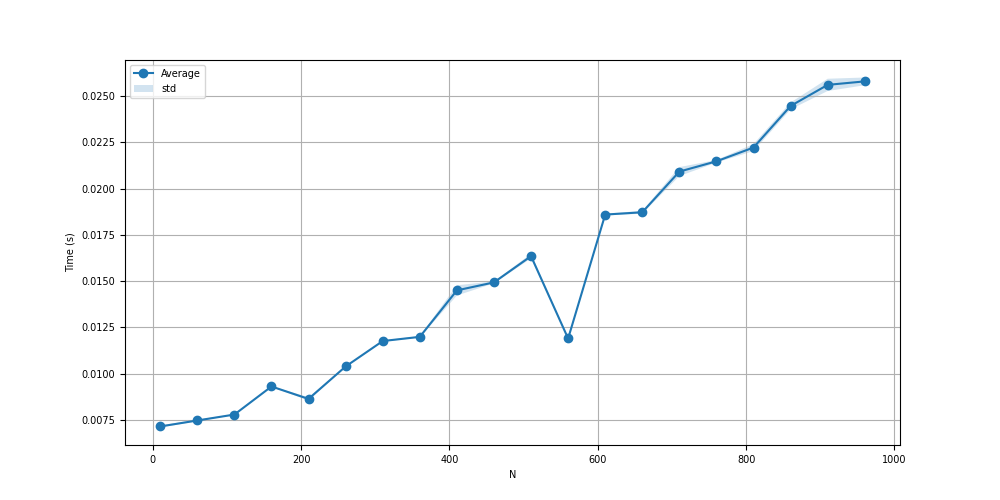

In [25]:
fig = plt.figure(figsize=(10, 5))
# Plot average and uncertainty
plt.plot(Ns, all_times, '-o', label="Average")
plt.fill_between(Ns, all_times - all_stds, all_times + all_stds, alpha=.2, label="std")
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()

## Vizualise Effect on Weights

In [86]:
# W = np.random.rand(100)
# b = 1.2
chout = np.random.randint(Ws.shape[0])
chout = 378
print(chout)
W = Ws[chout]
b = bs[chout]
W_unique = np.unique(W)

all_projs = []
for idx in tqdm(range(len(W_unique))):
    w_value = W_unique[idx]
    all_projs.append(IterativeProjection(Wini=W, bini=b, S=W >= w_value).solve())
    # all_times[N_idx] = tim.average
    # all_stds[N_idx] = tim.stdev

losses = np.array([proj.loss for proj in all_projs])
diff = losses[1:] - losses[:-1]
min_idx = losses.argmin()
print((diff[:min_idx] < 0).all(), (diff[min_idx:] > 0).all())
print(all_projs[min_idx])


  0%|          | 0/100 [00:00<?, ?it/s]

True True
IterativeProjection(Loss=5.1165e-01 Kbar: 13 K: 8 T: 13)


ValueError: cannot reshape array of size 100 into shape (28,28)

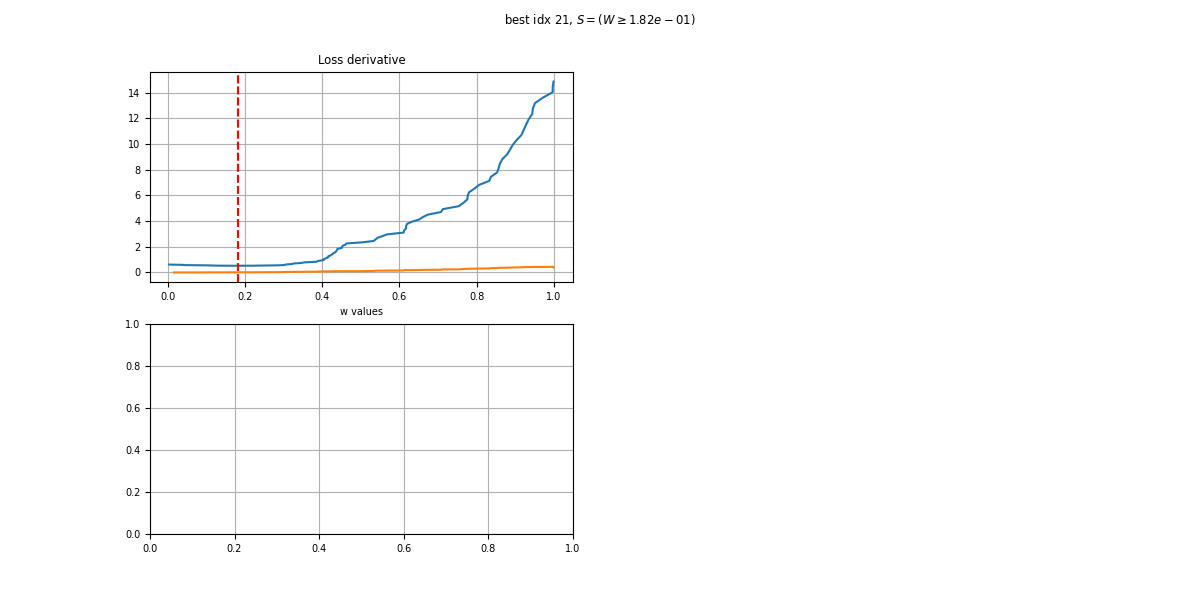

In [88]:
plt.figure(figsize=(12, 6))

plt.suptitle(rf"best idx {min_idx}, $S = (W \geq {W_unique[min_idx]:.2e})$")

plt.subplot(221)
plt.plot(W_unique, losses,)
plt.axvline(W_unique[min_idx], color='r', linestyle='--')
# plt.title("Loshttps://open-assistant.io/fr2)
plt.plot(W_unique[1:], diff,)
plt.axvline(W_unique[min_idx], color='r', linestyle='--')
plt.title("Loss derivative")
plt.xlabel("w values")

plt.subplot(223)
plt.imshow(W.reshape(28, 28), )
plt.grid(False)
# plt.title("W")

plt.subplot(224)
plt.imshow(W.reshape(28, 28) >= W_unique[min_idx], interpolation='nearest', cmap='gray')
plt.grid(False)
# plt.title("S")


## Tests

### Test Matrix System

In [17]:
prob1 = IterativeProjection(Wini=W, bini=b, S=S).solve()

print(f"Loss: {prob1.loss:.4f}, Kbar: {prob1.Kbar.sum()}, K: {prob1.K.sum()}, T: {prob1.T.sum()}")

prob1.X = np.concatenate([prob1.W[prob1.Kbar], prob1.lambda0,  prob1.lambdak[prob1.lambdak != 0], prob1.lambdat[prob1.lambdat != 0].reshape(-1), prob1.b])
prob1.Y = np.concatenate([W[prob1.Kbar], W[prob1.K], W[prob1.T], np.array([b, 0]),])
prob1.A = system(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())
prob1.Ainv = system_inv(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())


print((prob1.A@prob1.X - prob1.Y).sum())
print((prob1.Ainv@prob1.Y - prob1.X).sum())

Loss: 10.2215, Kbar: 5, K: 45, T: 17
7.216449660063518e-16
2.0361316799277773e-15


### Test dependence on $\mathbb K$

In [19]:
W_2 = W + 0
W_2[prob1.K] = W_2[prob1.K][-1]

prob_2 = IterativeProjection(Wini=W_2, bini=b, S=S).solve()
print(f"Loss: {prob_2.loss:.4f}, Kbar: {prob_2.Kbar.sum()}, K: {prob_2.K.sum()}, T: {prob_2.T.sum()}")

prob_2.X = np.concatenate([prob_2.W[prob_2.Kbar], prob_2.lambda0,  prob_2.lambdak[prob_2.lambdak != 0], prob_2.lambdat[prob_2.lambdat != 0].reshape(-1), prob_2.b])
prob_2.Y = np.concatenate([W_2[prob_2.Kbar], W_2[prob_2.K], W_2[prob_2.T], np.array([b, 0]),])
prob_2.A = system(prob_2.Kbar.sum(), prob_2.K.sum(), prob_2.T.sum())
prob_2.Ainv = system_inv(prob_2.Kbar.sum(), prob_2.K.sum(), prob_2.T.sum())


print((prob_2.A@prob_2.X - prob_2.Y).sum())
print((prob_2.Ainv@prob_2.Y - prob_2.X).sum())

Loss: 20.5861, Kbar: 5, K: 45, T: 17
4.440892098500626e-16
-6.76975836499949e-16


In [20]:
print("W1 = W2", np.isclose(prob1.W, prob_2.W).all())
print("b1 = b2", np.isclose(prob1.b, prob_2.b).all())

W1 = W2 True
b1 = b2 True


In [21]:
W_3 = W + 0
W_3[prob1.K] = 0

prob_3 = IterativeProjection(Wini=W_3, bini=b, S=S).solve()
print(f"Loss: {prob_3.loss:.4f}, Kbar: {prob_3.Kbar.sum()}, K: {prob_3.K.sum()}, T: {prob_3.T.sum()}")

prob_3.X = np.concatenate([prob_3.W[prob_3.Kbar], prob_3.lambda0,  prob_3.lambdak[prob_3.lambdak != 0], prob_3.lambdat[prob_3.lambdat != 0].reshape(-1), prob_3.b])
prob_3.Y = np.concatenate([W_3[prob_3.Kbar], W_3[prob_3.K], W_3[prob_3.T], np.array([b, 0]),])
prob_3.A = system(prob_3.Kbar.sum(), prob_3.K.sum(), prob_3.T.sum())
prob_3.Ainv = system_inv(prob_3.Kbar.sum(), prob_3.K.sum(), prob_3.T.sum())


print((prob_3.A@prob_3.X - prob_3.Y).sum())
print((prob_3.Ainv@prob_3.Y - prob_3.X).sum())

Loss: 2.6547, Kbar: 5, K: 45, T: 17
2.7755575615628914e-16
5.048045315092509e-16


In [22]:
print("W1 = W3", np.isclose(prob1.W, prob_3.W).all())
print("b1 = b3", np.isclose(prob1.b, prob_3.b).all())

W1 = W3 True
b1 = b3 True


### Test Erosion Dilation Equivalance (Not True)

In [105]:
Wuni = np.unique(W)
S = W > .6
b_dil = b + 0
b_ero = W.sum() - b

prob_dil = IterativeProjection(Wini=Wuni, bini=b_dil, S=S, operation="dilation").solve()
prob_ero = IterativeProjection(Wini=Wuni, bini=b_ero, S=S, operation="erosion").solve()

print("loss dil", prob_dil.loss)
print("loss ero", prob_ero.loss)

loss dil 3.3352128847382043
loss ero 6.302422935455022


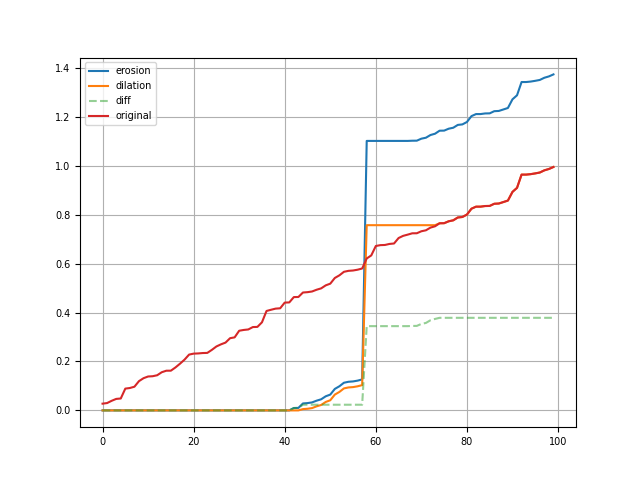

In [195]:
plt.figure()
plt.plot(prob_ero.W, label="erosion")
plt.plot(prob_dil.W, label="dilation")
plt.plot(prob_ero.W - prob_dil.W, label="diff", linestyle="--", alpha=.5)
plt.plot(W, label="original")
plt.legend()

### Test Multi Iteration

In [281]:
N, D = 100, 100
Ws = np.random.rand(N, D)

bs = np.random.rand(N)

S = np.random.rand(D) > .5

probs = [IterativeProjection(Wini=Ws[i], bini=bs[i], S=S).solve() for i in range(N)]

mprob = MultiIterativeProjection(Wini=Ws, bini=bs, S=S).solve()

print(mprob.value)
print(np.array([p.value for p in probs]).sum())
diff_loss = np.abs(np.array([p.loss for p in probs]) - mprob.loss)
print(f"{diff_loss.max():.2e}", f"{diff_loss.sum():.2e}")


698.5113873820237
698.5113873820237
8.88e-16 5.33e-15


In [254]:
%%timeit
probs = [IterativeProjection(Wini=Ws[i], bini=bs[i], S=S).solve() for i in range(N)]


865 ms ± 8.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [282]:
%%timeit
mprob = MultiIterativeProjection(Wini=Ws, bini=bs, S=S).solve()


197 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [312]:
D = 25
S = np.random.rand(D) > .5
Ns = np.arange(10, 200, 10)

times_single = []
stds_single = []
times_multi = []
stds_multi = []

for N in tqdm(Ns):
    
    Ws = np.random.rand(N, D)
    bs = np.random.rand(N)
    time_single = %timeit -o -q -n 5 -r 3 probs = [IterativeProjection(Wini=Ws[i], bini=bs[i], S=S).solve() for i in range(N)]
    time_multi = %timeit -o -q -n 5 -r 3 mprob = MultiIterativeProjection(Wini=Ws, bini=bs, S=S).solve()
    times_single.append(time_single.average)
    times_multi.append(time_multi.average)
    stds_single.append(time_single.stdev)
    stds_multi.append(time_multi.stdev)


  0%|          | 0/19 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Factor of speedup')

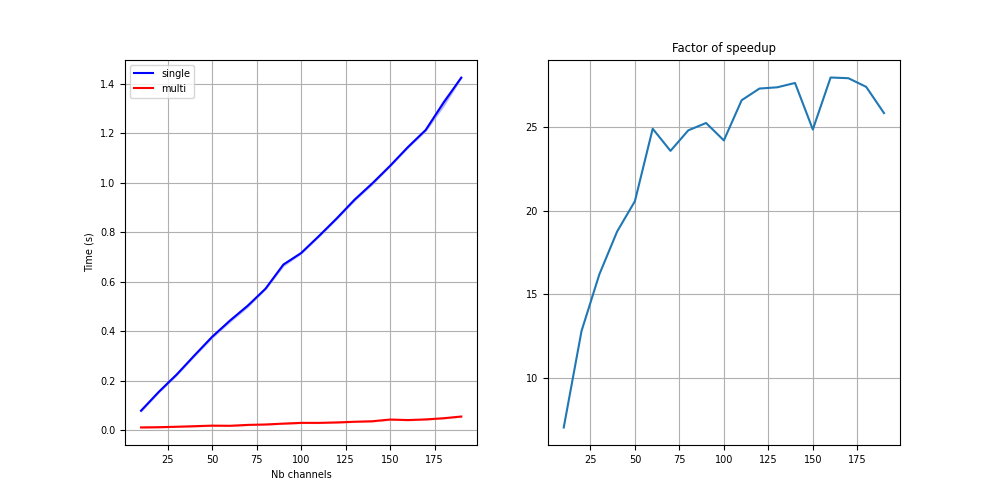

In [313]:
mplot = MultiPlot(1, 2, figsize=(10, 5))

ax = mplot.add_subplot((1, 1))
ax.plot(Ns[:len(times_single)], times_single, c="b", label="single")
ax.plot(Ns[:len(times_multi)], times_multi, c="r", label="multi")
ax.set_xlabel("Nb channels")
ax.set_ylabel("Time (s)")
ax.fill_between(Ns[:len(times_single)], np.array(times_single) - np.array(stds_single), np.array(times_single) + np.array(stds_single), color="b", alpha=.2)
ax.fill_between(Ns[:len(times_multi)], np.array(times_multi) - np.array(stds_multi), np.array(times_multi) + np.array(stds_multi), color="r", alpha=.2)
ax.legend()

ax = mplot.add_subplot((1, 2))
ax.plot(Ns[:len(times_single)], np.array(times_single)/np.array(times_multi), label="single")
ax.set_title("Factor of speedup")

In [328]:
N = 100
Ds = np.array([3, 5, 7, 9, 11, 13, 15, 17, 19, 21]) ** 2

times_single = []
stds_single = []
times_multi = []
stds_multi = []

for D in tqdm(Ds):
    
    S = np.random.rand(D) > .5
    Ws = np.random.rand(N, D)
    bs = np.random.rand(N)
    time_single = %timeit -o -q -n 1 -r 3 probs = [IterativeProjection(Wini=Ws[i], bini=bs[i], S=S).solve() for i in range(N)]
    time_multi = %timeit -o -q -n 1 -r 3 mprob = MultiIterativeProjection(Wini=Ws, bini=bs, S=S).solve()
    times_single.append(time_single.average)
    times_multi.append(time_multi.average)
    stds_single.append(time_single.stdev)
    stds_multi.append(time_multi.stdev)


  0%|          | 0/10 [00:00<?, ?it/s]

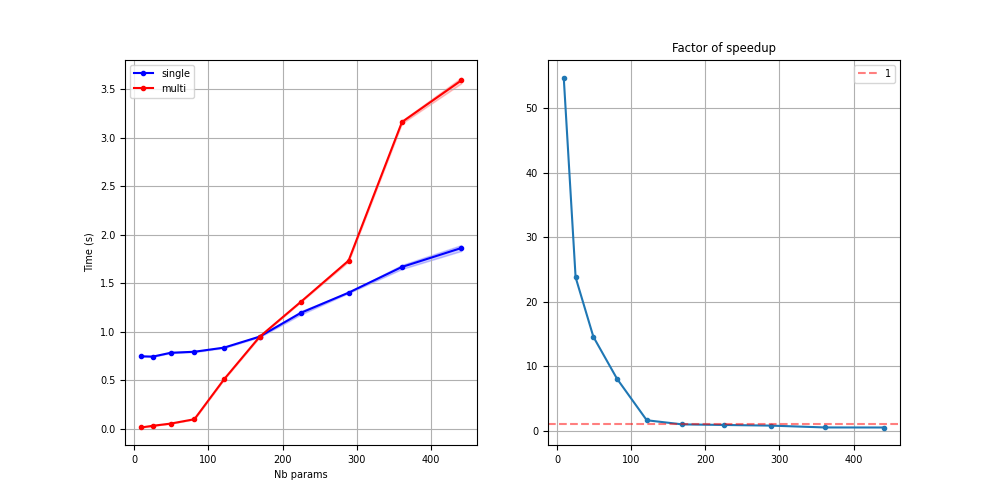

In [329]:
mplot = MultiPlot(1, 2, figsize=(10, 5))

ax = mplot.add_subplot((1, 1))
ax.plot(Ds[:len(times_single)], times_single, c="b", label="single", marker=".")
ax.plot(Ds[:len(times_multi)], times_multi, c="r", label="multi", marker=".")
ax.set_xlabel("Nb params")
ax.set_ylabel("Time (s)")
ax.fill_between(Ds[:len(times_single)], np.array(times_single) - np.array(stds_single), np.array(times_single) + np.array(stds_single), color="b", alpha=.2)
ax.fill_between(Ds[:len(times_multi)], np.array(times_multi) - np.array(stds_multi), np.array(times_multi) + np.array(stds_multi), color="r", alpha=.2)
ax.legend()

ax = mplot.add_subplot((1, 2))
ax.plot(Ds[:len(times_single)], np.array(times_single)/np.array(times_multi), marker=".")
ax.set_title("Factor of speedup")
ax.axhline(1, linestyle="--", color="r", alpha=.5, label="1")
ax.legend()

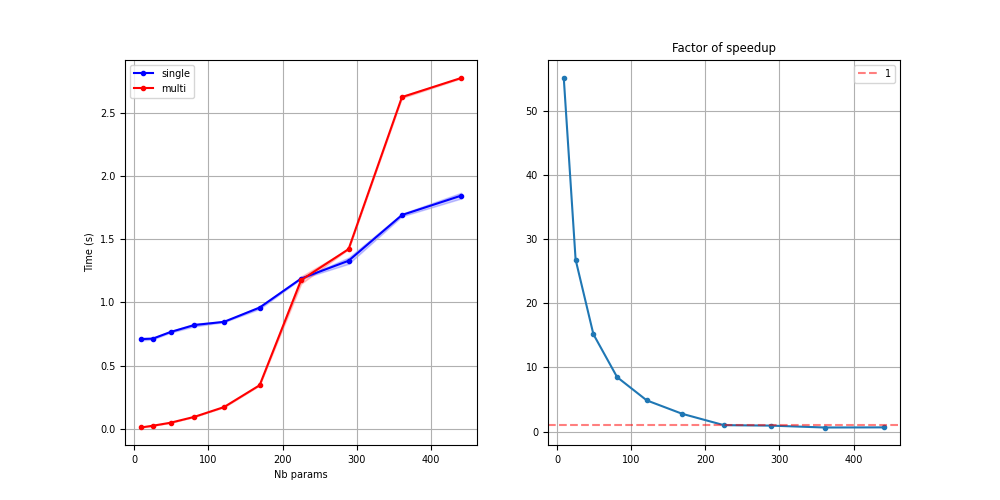

In [326]:
mplot = MultiPlot(1, 2, figsize=(10, 5))

ax = mplot.add_subplot((1, 1))
ax.plot(Ds[:len(times_single)], times_single, c="b", label="single", marker=".")
ax.plot(Ds[:len(times_multi)], times_multi, c="r", label="multi", marker=".")
ax.set_xlabel("Nb params")
ax.set_ylabel("Time (s)")
ax.fill_between(Ds[:len(times_single)], np.array(times_single) - np.array(stds_single), np.array(times_single) + np.array(stds_single), color="b", alpha=.2)
ax.fill_between(Ds[:len(times_multi)], np.array(times_multi) - np.array(stds_multi), np.array(times_multi) + np.array(stds_multi), color="r", alpha=.2)
ax.legend()

ax = mplot.add_subplot((1, 2))
ax.plot(Ds[:len(times_single)], np.array(times_single)/np.array(times_multi), marker=".")
ax.set_title("Factor of speedup")
ax.axhline(1, linestyle="--", color="r", alpha=.5, label="1")
ax.legend()

### Test cvxpy slicing vs dot product

In [570]:
np.arange(3*4).reshape(3, 4).reshape(3*4)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [617]:
@dataclass
class MultiIterativeProjectionSelem:
    Wini: np.ndarray
    bini: float
    operation: str = "dilation"

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        # self.Wvar = cp.Variable(self.N)
        self.Wvar = cp.Variable(self.N * self.N)
        self.bvar = cp.Variable(self.N)

        Wini_multi = np.concatenate([Wini for _ in range(self.N)])
        bini_multi = np.array([bini for _ in range(self.N)])

        # self.constraint0 = [cp.sum(self.Wvar[~self.S]) <= self.bvar]
        # self.constraintsT = [self.bvar <= self.Wvar[self.S]]
        # self.constraintsK = [self.Wvar >= 0]

        # self.constraints = self.constraint0 + self.constraintsT + self.constraintsK
        if self.operation == "dilation":
            self.constraints = self.dilation_constraints(self.Wvar, self.bvar, )
        elif self.operation == "erosion":
            self.constraints = self.erosion_constraints(self.Wvar, self.bvar, )
        else:
            raise ValueError("operation must be dilation or erosion")

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - Wini_multi) + 1/2 * cp.sum_squares(self.bvar - bini_multi))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()
        self.loss = 1/2 * (((self.W_flatten - Wini_multi)**2).reshape(self.N, self.N).sum(1) + ((self.b_flatten - bini_multi)**2))

        return self

    def dilation_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, ):
        C1 = self.C1(self.N)
        C2 = self.C2(self.N)
        b2 = self.b2(self.N)
        self.constraint0 = [C1 @ Wvar <= bvar]
        self.constraintsT = [(C2 @ Wvar) >= (b2 @ bvar)]
        self.constraintsK = [Wvar >= 0]
        return self.constraint0 + self.constraintsT + self.constraintsK

    @staticmethod
    def C1(N: int):
        row_idxes = np.empty(N * (N-1) // 2, dtype=int)
        col_idxes = np.empty(N * (N-1) // 2, dtype=int)

        cur_idx = 0
        for k in range(N):
            for i in range(k):
                row_idxes[cur_idx] = k
                col_idxes[cur_idx] = N * k + i
                cur_idx += 1

        return sparse.coo_matrix((np.ones(len(row_idxes)), (row_idxes, col_idxes)), shape=(N, N*N))

    @staticmethod
    def C2(N: int):
        row_idxes = np.empty(N * (N+1) // 2, dtype=int)
        col_idxes = np.empty(N * (N+1) // 2, dtype=int)

        cur_row = 0
        cur_idx = 0
        for k in range(N):
            for i in range(N - k):
                row_idxes[cur_idx] = cur_row + i
                col_idxes[cur_idx] = i + k * (N + 1)
                cur_idx += 1
            cur_row += N -k

        return sparse.coo_matrix((np.ones(len(row_idxes)), (row_idxes, col_idxes)), shape=(N * (N+1) // 2, N*N))

    @staticmethod
    def b2(N: int):
        row_idxes = np.arange(N * (N+1) // 2, dtype=int)
        col_idxes = np.empty(N * (N+1) // 2, dtype=int)

        cur_idx = 0
        for k in range(N):
            col_idxes[cur_idx:cur_idx + N-k] = k
            cur_idx += N-k

        return sparse.coo_matrix((np.ones(len(row_idxes)), (row_idxes, col_idxes)), shape=(N * (N+1) // 2, N))


    @property
    def W_flatten(self):
        return self.Wvar.value
    
    @property
    def b(self):
        return self.b_flatten

    @property
    def W(self):
        return self.W_flatten.reshape(self.N, self.N)

    @property
    def b_flatten(self):
        return self.bvar.value

    @property
    def value(self):
        return self.prob.value



In [653]:
N = 200
Wini = np.random.randn(N)
bini = 1.2

all_S = np.kron(np.arange(N), np.ones((N, 1))) >= np.kron(np.arange(N), np.ones((N, 1))).T

# MultiIterativeProjectionSelem.C2(N)
t1 = time()
mprob = MultiIterativeProjectionSelem(Wini, bini, operation="dilation").solve()
print(time() - t1)

probs = []
pbar = tqdm(total=len(all_S))
for S in all_S:
    probs.append(IterativeProjection(Wini, bini, S, operation="dilation").solve())
    pbar.update(1)

# probs = [IterativeProjection(Wini, bini, S, operation="dilation").solve() for S in all_S]

1.8596808910369873


  0%|          | 0/200 [00:00<?, ?it/s]

In [654]:
((mprob.loss - np.array([prob.loss for prob in probs])) / mprob.loss)

array([ 1.10954185e-05,  1.38623016e-05, -8.99633104e-10,  7.40439227e-10,
        1.74223889e-07,  3.63380957e-08,  5.26530794e-06,  4.26060073e-07,
        1.80094309e-06,  4.02573679e-06,  2.86866642e-06,  6.80237733e-06,
        2.29743036e-06,  1.46041627e-06,  1.41623245e-05,  5.10056146e-06,
        1.23514643e-05,  1.03470676e-05,  7.10870222e-06,  1.71388032e-05,
        1.24776418e-05,  1.02323591e-05,  1.69183156e-05,  2.63549506e-05,
        2.45403170e-05,  3.18933540e-05,  9.99138731e-06,  1.37083554e-05,
        3.58312621e-05,  2.93271773e-05,  3.96596048e-05,  2.60578557e-05,
        3.81089021e-05,  5.17221129e-05,  5.47726900e-05,  6.03347733e-05,
        4.41412314e-05,  4.19776195e-05,  4.15179411e-05,  4.79237112e-05,
        6.47139704e-05,  4.29175506e-05,  6.01289049e-05,  4.51239061e-05,
        5.31986210e-05,  4.44823631e-05,  7.16537234e-05,  4.84982826e-05,
        5.84405097e-05,  6.80810051e-05,  3.57020086e-05,  4.22593027e-05,
        8.45885459e-05,  

In [655]:
%%timeit
probs = [IterativeProjection(Wini, bini, S, operation="dilation").solve() for S in all_S]


3.55 s ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [656]:
%%timeit
mprob = MultiIterativeProjectionSelem(Wini, bini, operation="dilation").solve()


1.95 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [660]:
%%timeit
MultiIterativeProjectionSelem.C1(N)

5.75 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [661]:
%%timeit
MultiIterativeProjectionSelem.C2(N)

6.66 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [662]:
%%timeit
MultiIterativeProjectionSelem.b2(N)

224 µs ± 5.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [659]:
MultiIterativeProjectionSelem.C2(3).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [515]:
%%timeit
# A = -np.stack([np.diag(np.ones(N-k), k=k) for k in range(N)])
A = np.zeros((N * (N+1) // 2, N*N))
cur_row = 0
cur_col = 0
for k in range(N, 0, -1):
    A[cur_row:cur_row+k, (N+cur_col)-k:N+cur_col] = -np.eye(k)
    cur_row += k
    cur_col += N

5.94 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [567]:
%%timeit
row_idxes = np.empty(N * (N-1) // 2, dtype=int)
col_idxes = np.empty(N * (N-1) // 2, dtype=int)

cur_idx = 0
for k in range(N):
    for i in range(k):
        row_idxes[cur_idx] = k
        col_idxes[cur_idx] = N * k + i
        cur_idx += 1

spC = sparse.coo_matrix((np.ones(len(row_idxes)), (row_idxes, col_idxes)), shape=(N, N*N))

143 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [564]:
spC.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [518]:
%%timeit

row_idxes = np.empty(N * (N+1) // 2, dtype=int)
col_idxes = np.empty(N * (N+1) // 2, dtype=int)

cur_row = 0
cur_idx = 0
for k in range(N):
    for i in range(N - k):
        row_idxes[cur_idx] = cur_row + i
        col_idxes[cur_idx] = i + k * (N + 1)
        cur_idx += 1
    cur_row += N -k

spA = sparse.coo_matrix((-np.ones(len(row_idxes)), (row_idxes, col_idxes)))

177 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [492]:
A

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [491]:
A2

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [512]:
A2 = spA.toarray()

In [513]:
A2.shape

(55, 100)

In [385]:
%%timeit
np.tri(N, k=-1)

494 µs ± 968 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [350]:
@dataclass
class SlicingProjection:
    Wini: np.ndarray
    bini: float
    S: np.ndarray
    operation: str = "dilation"

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        # self.Wvar = cp.Variable(self.N)
        self.Wvar = cp.Variable(self.Wini.shape)
        self.bvar = cp.Variable(self.bini.shape)

        # self.constraint0 = [cp.sum(self.Wvar[~self.S]) <= self.bvar]
        # self.constraintsT = [self.bvar <= self.Wvar[self.S]]
        # self.constraintsK = [self.Wvar >= 0]

        # self.constraints = self.constraint0 + self.constraintsT + self.constraintsK
        if self.operation == "dilation":
            self.constraints = self.dilation_constraints(self.Wvar, self.bvar, self.S)
        elif self.operation == "erosion":
            self.constraints = self.erosion_constraints(self.Wvar, self.bvar, self.S)
        else:
            raise ValueError("operation must be dilation or erosion")

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - self.Wini) + 1/2 * cp.sum_squares(self.bvar - self.bini))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()
        self.loss = 1/2 * (((self.W - self.Wini)**2).sum(1) + ((self.b - self.bini)**2))

        return self

    def dilation_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
        self.constraint0 = [cp.sum(Wvar[:, ~S], axis=1) <= bvar]
        self.constraintsT = [bvar <= cp.min(Wvar[:, S], axis=1)]
        self.constraintsK = [Wvar >= 0]
        return self.constraint0 + self.constraintsT + self.constraintsK

    # def erosion_constraints(self, Wvar: cp.Variable, bvar: cp.Variable, S: np.ndarray):
    #     self.constraint0 = [cp.sum(Wvar[S]) >= bvar]
    #     self.constraintsT = [cp.sum(Wvar) - Wvar[S] <= bvar]
    #     self.constraintsK = [Wvar >= 0]
    #     return self.constraint0 + self.constraintsT + self.constraintsK

    @property
    def W(self):
        return self.Wvar.value
    
    @property
    def b(self):
        return self.bvar.value

    @property
    def K(self):
        return np.isclose(self.W, 0) & ~self.S

    @property
    def Kbar(self):
        return ~self.S & ~self.K
    
    @property
    def T(self):
        return np.isclose(self.W, self.b) & self.S

    @property
    def lambda0(self):
        return self.constraint0[0].dual_value
    
    @property
    def lambdat(self):
        return np.array([constraint.dual_value for constraint in self.constraintsT])
    
    @property
    def lambdak(self):
        return np.array([constraint.dual_value for constraint in self.constraintsK])

    @property
    def value(self):
        return self.prob.value
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"Loss={self.loss:.4e} "
            f"Kbar: {self.Kbar.sum()} K: {self.K.sum()} T: {self.T.sum()}"
            ")"
        )


150.15

## Check Threshold

### Best S

In [89]:
N = 10
Wini = np.unique(np.random.rand(N))
Wini = Wini / Wini.sum()
bini = Wini.sum() / 2


In [90]:

all_probs_dil = OrderedDict()
all_probs_ero = OrderedDict()

pbar = tqdm(total=2**N-1)

for set_ in powerset(range(N)):
    S = np.zeros(N, dtype=bool)
    S[list(set_)] = True
    all_probs_dil[set_] = IterativeProjection(Wini=Wini, bini=bini, S=S, operation="dilation").solve()
    all_probs_ero[set_] = IterativeProjection(Wini=Wini, bini=bini, S=S, operation="erosion").solve()
    pbar.update(1)



  0%|          | 0/1023 [00:00<?, ?it/s]

[0.01789799 0.02246203 0.02678551 0.06480941 0.11371371 0.12053023
 0.14592591 0.15027992 0.1628285  0.1747668 ]
(9,)
(6, 7, 8, 9)
True


Text(0.5, 1.0, 'ero $S^*$. Loss: 0.0074')

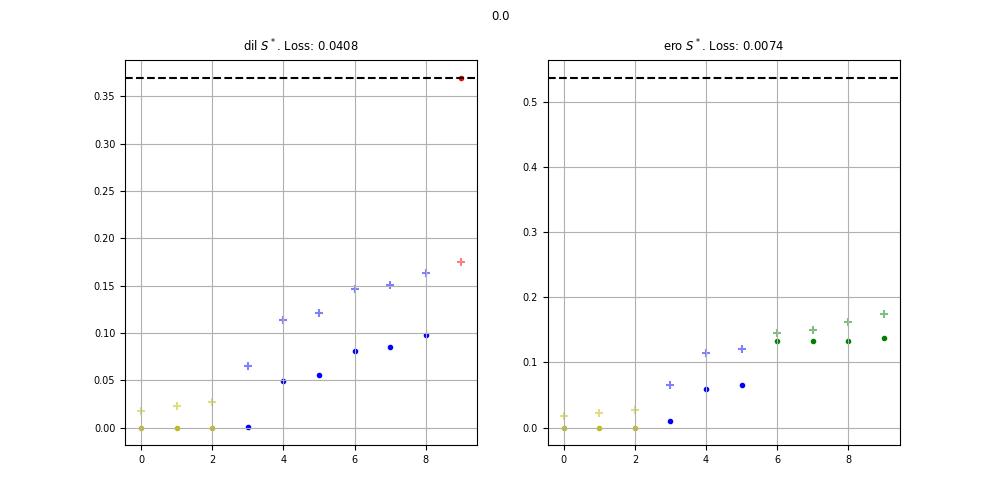

In [92]:
best_set_dil = min(all_probs_dil, key=lambda x: all_probs_dil[x].loss)
best_set_ero = min(all_probs_ero, key=lambda x: all_probs_ero[x].loss)

best_proj_dil = all_probs_dil[best_set_dil]
best_proj_ero = all_probs_ero[best_set_ero]

print(Wini)
print(best_set_dil)
print(best_set_ero)
print(Wini[best_proj_dil.S].min() > Wini[~best_proj_dil.S].max())

mplot = MultiPlot(1, 2, figsize=(10, 5))

mplot.fig.suptitle(f"{Wini.sum() / 2 - bini}")

ax = mplot.add_subplot((1, 1))
ax.axhline(best_proj_dil.b, color="k", linestyle="--", label="b")
plot_sets_on_ax(W=Wini, K=best_proj_dil.K, T=best_proj_dil.T, S=best_proj_dil.S, ax=ax, marker="+", alpha=.5)
plot_sets_on_ax(W=best_proj_dil.W, K=best_proj_dil.K, T=best_proj_dil.T, S=best_proj_dil.S, ax=ax, marker=".")
ax.set_title(f"dil $S^*$. Loss: {best_proj_dil.loss:.4f}")
# ax.legend()

ax = mplot.add_subplot((1, 2))
ax.axhline(best_proj_ero.b, color="k", linestyle="--", label="b")
plot_sets_on_ax(W=Wini, K=best_proj_ero.K, T=best_proj_ero.T, S=best_proj_ero.S, ax=ax, marker="+", alpha=.5)
plot_sets_on_ax(W=best_proj_ero.W, K=best_proj_ero.K, T=best_proj_ero.T, S=best_proj_ero.S, ax=ax, marker=".")
ax.set_title(f"ero $S^*$. Loss: {best_proj_ero.loss:.4f}")
# ax.legend()

In [193]:
all_probs_dil[best_set_ero]

IterativeProjection(Loss=4.7855e-02 Kbar: 6 K: 0 T: 4)

In [192]:
print(best_proj_dil.W.sum() / 2 - best_proj_dil.b)
print(best_proj_ero.W.sum() / 2 - best_proj_ero.b)


[-5.55111512e-17]
[-0.20269191]


### Swap Indexes

In [100]:
N = 200
Wini = np.unique(np.random.rand(N))
bini = 1.2

S1 = np.zeros(N, dtype=bool)
S1[random.sample(range(N), N // 2)] = True

170 171


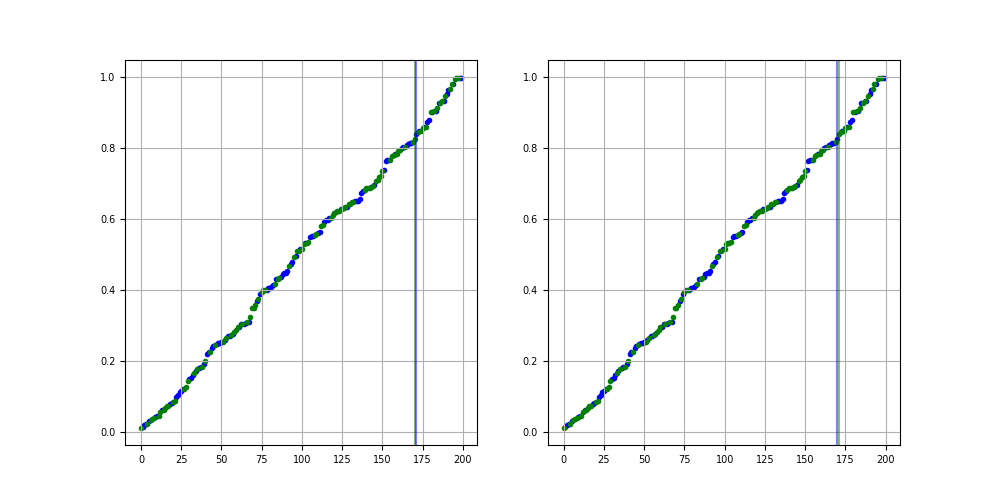

In [101]:
# idx1, idx2 = random.choice(np.where(S1)[0]), random.choice(np.where(~S1)[0])
# idx1, idx2 = 35, 36  # i, j in T, K
# idx1, idx2 = 190, 191

# Max and Min
# idx1 = np.where(S1, Wini, +np.infty).argmin()
# idx2 = np.where(~S1, Wini, -np.infty).argmax()

# Consecutive
cons_S = S1[:-1] & ~S1[1:]
idx1 = random.choice(np.where(cons_S)[0])
idx2 = idx1 + 1


print(idx1, idx2)
S2 = S1.copy()
S2[idx1], S2[idx2] = S2[idx2], S2[idx1]


plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_ini_on_ax(W=Wini, S=S1)
plt.axvline(idx1, color="g", label="idx1", alpha=.5)
plt.axvline(idx2, color="b", label="idx2", alpha=.5)

plt.subplot(122)
plot_ini_on_ax(W=Wini, S=S2)
plt.axvline(idx1, color="b", label="idx1", alpha=.5)
plt.axvline(idx2, color="g", label="idx2", alpha=.5)


In [666]:
def compute_checks():
    cons_S = S1[:-1] & ~S1[1:]
    KO_T = []
    KO_K = []
    KO_K1K2 = []
    KO_T1T2 = []

    for idx1 in tqdm(np.where(cons_S)[0]):
        idx2 = idx1 + 1
        S2 = S1.copy()
        S2[idx1], S2[idx2] = S2[idx2], S2[idx1]
        prob1 = IterativeProjection(Wini=Wini, bini=bini, S=S1).solve()
        prob2 = IterativeProjection(Wini=Wini, bini=bini, S=S2).solve()
        if prob1.T[idx1] != prob2.T[idx2]:
            KO_T.append(idx1)

        if prob1.K[idx2] != prob2.K[idx1]:
            KO_K.append(idx1)

        K1 = set(np.where(prob1.K)[0])
        K2 = set(np.where(prob2.K)[0])
        T1 = set(np.where(prob1.T)[0])
        T2 = set(np.where(prob2.T)[0])

        if K1.difference([idx2]) != K2.difference([idx1]):
            KO_K1K2.append(idx1)
        
        if T1.difference([idx1]) != T2.difference([idx2]):
            KO_T1T2.append(idx1)

    return KO_T, KO_K, KO_K1K2, KO_T1T2

KO_T, KO_K, KO_K1K2, KO_T1T2 = compute_checks()
print(len(KO_T), len(KO_K), len(KO_K1K2), len(KO_T1T2))


0it [00:00, ?it/s]

0 0 0 0


In [667]:
idx1 = 80
idx2 = 81
S2 = S1.copy()
S2[idx1], S2[idx2] = S2[idx2], S2[idx1]

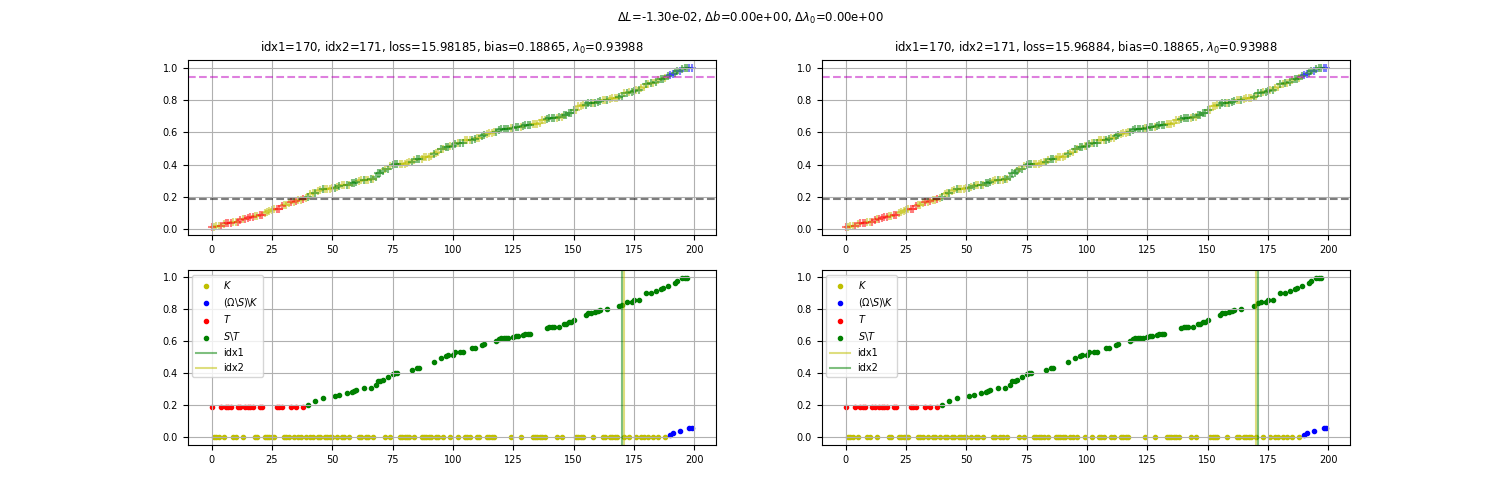

In [102]:
prob1 = IterativeProjection(Wini=Wini, bini=bini, S=S1).solve()
prob2 = IterativeProjection(Wini=Wini, bini=bini, S=S2).solve()


mplot = MultiPlot(2, 2, figsize=(15, 5))

mplot.fig.suptitle(fr"$\Delta L$={prob2.loss - prob1.loss:.2e}, $\Delta b$={prob2.b[0] - prob1.b[0]:.2e}, $\Delta \lambda_0$={prob2.lambda0[0] - prob1.lambda0[0]:.2e}")

ax = mplot.add_subplot((1, 1))
plot_sets_on_ax(W=Wini, K=prob1.K, T=prob1.T, S=prob1.S, ax=ax, marker="+", alpha=.5)
ax.set_title(fr"idx1={idx1}, idx2={idx2}, loss={prob1.loss:.5f}, bias={prob1.b[0]:.5f}, $\lambda_0$={prob1.lambda0[0]:.5f}")
ax.axhline(prob1.b[0], color="k", alpha=.5, linestyle="--")
ax.axhline(prob1.lambda0[0], color="m", alpha=.5, linestyle="--")

ax = mplot.add_subplot((2, 1))
plot_sets_on_ax(W=prob1.W, K=prob1.K, T=prob1.T, S=prob1.S, ax=ax, marker=".")
plt.axvline(idx1, color="r" if prob1.T[idx1] else "g", label="idx1", alpha=.5)
plt.axvline(idx2, color="y" if prob1.K[idx2] else "b", label="idx2", alpha=.5)
ax.legend()

ax = mplot.add_subplot((1, 2))
plot_sets_on_ax(W=Wini, K=prob2.K, T=prob2.T, S=prob2.S, ax=ax, marker="+", alpha=.5)
ax.set_title(f"idx1={idx1}, idx2={idx2}, loss={prob2.loss:.5f}, bias={prob2.b[0]:.5f}, $\lambda_0$={prob2.lambda0[0]:.5f}")
ax.axhline(prob2.b[0], color="k", alpha=.5, linestyle="--")
ax.axhline(prob2.lambda0[0], color="m", alpha=.5, linestyle="--")


ax = mplot.add_subplot((2, 2))
plot_sets_on_ax(W=prob2.W, K=prob2.K, T=prob2.T, S=prob2.S, ax=ax, marker=".")
plt.axvline(idx1, color="y" if prob2.K[idx1] else "b", label="idx1", alpha=.5)
plt.axvline(idx2, color="r" if prob2.T[idx2] else "g", label="idx2", alpha=.5)
ax.legend()

In [279]:
print(f"i={idx1}, j={idx2}")
print(r"T1 \ T2 =", set(np.where(prob1.T)[0]).difference(set(np.where(prob2.T)[0])))
print(r"T2 \ T1 =", set(np.where(prob2.T)[0]).difference(set(np.where(prob1.T)[0])))

print(r"Kbar1 \ Kbar2 =", set(np.where(prob1.Kbar)[0]).difference(set(np.where(prob2.Kbar)[0])))
print(r"Kbar2 \ Kbar1 =", set(np.where(prob2.Kbar)[0]).difference(set(np.where(prob1.Kbar)[0])))

print(r"K1 \ K2 =", set(np.where(prob1.K)[0]).difference(set(np.where(prob2.K)[0])))
print(r"K2 \ K1 =", set(np.where(prob2.K)[0]).difference(set(np.where(prob1.K)[0])))


i=80, j=81
T1 \ T2 = {80}
T2 \ T1 = {81}
Kbar1 \ Kbar2 = set()
Kbar2 \ Kbar1 = set()
K1 \ K2 = {81}
K2 \ K1 = {80}


In [74]:
print("Check that the sets are the same")
print(prob1.K.sum(), prob1.T.sum(), prob1.Kbar.sum())
print(prob2.K.sum(), prob2.T.sum(), prob2.Kbar.sum())
print("=====================================")

A = system(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())
Ainv = system_inv(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())

prob1.X = np.concatenate([prob1.W[prob1.Kbar], prob1.lambda0,  prob1.lambdak[prob1.lambdak != 0], prob1.lambdat[prob1.lambdat != 0].reshape(-1), prob1.b])
prob1.Y = np.concatenate([Wini[prob1.Kbar], Wini[prob1.K], Wini[prob1.T], np.array([bini, 0]),])

prob2.X = np.concatenate([prob2.W[prob2.Kbar], prob2.lambda0,  prob2.lambdak[prob2.lambdak != 0], prob2.lambdat[prob2.lambdat != 0].reshape(-1), prob2.b])
prob2.Y = np.concatenate([Wini[prob2.Kbar], Wini[prob2.K], Wini[prob2.T], np.array([bini, 0]),])


print("Check that the solution 1 is OK")
print((A@prob1.X - prob1.Y).sum())
print((Ainv@prob1.Y - prob1.X).sum())
print("=====================================")

print("Check that the solution 2 is OK")
print((A@prob2.X - prob2.Y).sum())
print((Ainv@prob2.Y - prob2.X).sum())


Check that the sets are the same
95 20 5
93 20 7
Check that the solution 1 is OK
6.897260540483785e-15
-4.529146155340946e-15
Check that the solution 2 is OK
-89.02786618099569
-2.2238697490120627


In [55]:
print("Check that the loss 1 is OK")
print(prob1.loss)
print(((Wini[prob1.K]**2).sum() + prob1.lambda0 ** 2 * prob1.Kbar.sum() + ((prob1.b - Wini[prob1.T]) ** 2).sum() + (prob1.b - bini)**2)[0]/2)
print("=====================================")

print("Check that the loss 2 is OK")
print(prob2.loss)
print(((Wini[prob2.K]**2).sum() + prob2.lambda0 ** 2 * prob2.Kbar.sum() + ((prob2.b - Wini[prob2.T]) ** 2).sum() + (prob2.b - bini)**2)[0]/2)

Check that the loss 1 is OK
16.22950450119693
16.22950450119693
Check that the loss 2 is OK
16.227983380988793
16.227983380988793


#### $(i, j) \in (T(S_1) \times K(S_1)) \bigcup (K(S_2) \times T(S_2))$

In [39]:
print("First Check")
print(prob1.lambda0 ** 2 - prob2.lambda0 ** 2)
print(
    (Wini[idx2] - Wini[idx1]) * (2 * (prob1.T.sum() + 1) * Wini[prob1.Kbar].sum() - 2*bini -2 * (Wini[prob1.T].sum() - Wini[idx1]) - (Wini[idx1] + Wini[idx2]) ) 
    / (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2
)
print("=====================================")

print("Second Check")
print(((prob1.b - Wini[prob1.T]) ** 2).sum() - ((prob2.b - Wini[prob2.T]) ** 2).sum())
print(
    (Wini[idx2] - Wini[idx1]) * 
    (
        2 * (prob1.Kbar.sum() + 1) * Wini[prob1.Kbar].sum() + 
        2 * prob1.Kbar.sum() * (prob1.Kbar.sum() + 1) * bini + 
        2 * (prob1.Kbar.sum()) * ( prob1.Kbar.sum() * (prob1.T.sum() + 2) + 2) * (Wini[prob1.T].sum() - Wini[idx1]) -
        (prob1.Kbar.sum() ** 2 * (prob1.T.sum() - 1) + (prob1.Kbar.sum() * prob1.T.sum() + 1)**2) * (Wini[idx1] + Wini[idx2])
    ) /
    (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2
)
print("=====================================")

print("Third Check")
print((prob1.b - bini)**2 - (prob2.b - bini)**2)
print(
    (prob1.Kbar.sum() * (Wini[idx1] - Wini[idx2])) *
    (
        2 * Wini[prob1.Kbar].sum() + 2 *  prob1.Kbar.sum() * (Wini[prob1.T].sum() - Wini[idx1]) - 2 * (prob1.Kbar.sum() * prob1.T.sum() + 1) * bini + prob1.Kbar.sum() * (Wini[idx1] + Wini[idx2])
    ) /
    (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2
)
print("=====================================")

print("Fourth check")
print((Wini[prob1.K]**2).sum() - (Wini[prob2.K]**2).sum())
print(
    (Wini[idx2] - Wini[idx1]) * (Wini[idx2] + Wini[idx1])
)

First Check
[0.00022803]
0.0002280266854391644
Second Check
-0.0014012019783212204
-0.0014012019783211209
Third Check
[0.00118195]
0.0011819483526114866
Fourth check
0.004565942966006986
0.004565942966008454


In [40]:
print(2*(prob1.loss - prob2.loss))
print((
    Kb * (prob1.lambda0 ** 2 - prob2.lambda0 ** 2) +
    ((prob1.b - Wini[prob1.T]) ** 2).sum() - ((prob2.b - Wini[prob2.T]) ** 2).sum() +
    (prob1.b - bini)**2 - (prob2.b - bini)**2 +
    (Wini[prob1.K]**2).sum() - (Wini[prob2.K]**2).sum()  
))

0.005486822767494459
[0.00639893]


In [51]:
Tc = prob1.T.sum()
Kb = prob1.Kbar.sum()

Tsum = Wini[prob1.T].sum() - Wini[idx1]
Kbsum = Wini[prob1.Kbar].sum()

print(2 * (prob1.loss - prob2.loss))
print((
    # (Wini[idx2] - Wini[idx1]) * (2 * (prob1.T.sum() + 1) * Wini[prob1.Kbar].sum() - 2*bini -2 * (Wini[prob1.T].sum() - Wini[idx1]) - (Wini[idx1] + Wini[idx2]) ) 
    # / (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2 * Kb   # lambda0
    # + (Wini[idx2] - Wini[idx1]) * (Wini[idx2] + Wini[idx1])  # sum on K
    # + (
    #     (Wini[idx2] - Wini[idx1]) * 
    #     (
    #         2 * (prob1.Kbar.sum() + 1) * Wini[prob1.Kbar].sum() + 
    #         2 * prob1.Kbar.sum() * (prob1.Kbar.sum() + 1) * bini + 
    #         2 * (prob1.Kbar.sum()) * ( prob1.Kbar.sum() * (prob1.T.sum() + 2) + 2) * (Wini[prob1.T].sum() - Wini[idx1]) -
    #         (prob1.Kbar.sum() ** 2 * (prob1.T.sum() - 1) + (prob1.Kbar.sum() * prob1.T.sum() + 1)**2) * (Wini[idx1] + Wini[idx2])
    #     ) /
    #     (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2
    # )  # sum on T(
    # + (
    #     (prob1.Kbar.sum() * (Wini[idx1] - Wini[idx2])) *
    #     (
    #         2 * Wini[prob1.Kbar].sum() + 2 *  prob1.Kbar.sum() * (Wini[prob1.T].sum() - Wini[idx1]) - 2 * (prob1.Kbar.sum() * prob1.T.sum() + 1) * bini + prob1.Kbar.sum() * (Wini[idx1] + Wini[idx2])
    #     ) /
    #     (prob1.Kbar.sum() * (prob1.T.sum() +1) +1)**2
    # )
    # )
    (Wini[idx2] - Wini[idx1]) / (Kb * (Tc + 1) + 1) **2 * (
        Kbsum * (2 * (Kb * (Tc + 1) + 1)) +
        Tsum * (2 * Kb * (Kb * (Tc + 1) + 1)) +
        bini * 2 * Kb * (Kb * (Tc + 1) + 1) +
        (Wini[idx1] + Wini[idx2]) * Kb * (Kb * (Tc + 1) + 1)
    )
    # (Wini[idx2] - Wini[idx1]) / (Kb * (Tc + 1) + 1) **2 * (
    #     Kbsum * (Kb * 2 * (Tc + 1) + 2 * (Kb + 1) - 2 * Kb) +
    #     Tsum * (-2 * Kb + 2 * Kb * (Kb * (Tc + 2) + 2) - 2 * Kb ** 2) +
    #     bini * (-2 * Kb + 2 * Kb * (Kb + 1) + 2 * Kb * (Kb * Tc + 1)) +
    #     (Wini[idx1] + Wini[idx2]) * ((Kb * (Tc + 1) + 1) ** 2 - Kb - (Kb ** 2 * (Tc - 1) + (Kb * Tc + 1) ** 2) - Kb ** 2)
    # )
))

0.005486822767494459
0.005486822767494641


In [50]:
print(((Kb * (Tc + 1) + 1) ** 2 - Kb - (Kb ** 2 * (Tc - 1) + (Kb * Tc + 1) ** 2) - Kb ** 2))
print(Kb * (Kb * (Tc + 1) + 1))

530
530


In [42]:
print("b(S1) - b(S2)")
print(prob1.b - prob2.b)
print(Kb / (Kb * (Tc + 1) + 1) * (Wini[idx1] - Wini[idx2]))
print("=====================================")

print("b(S1) + b(S2)")
print(prob1.b + prob2.b)
print(1 / (Kb * (Tc + 1) + 1) * (2 * Kbsum + 2 * Kb * (Tsum + bini) + Kb * Wini[idx1] + Kb * Wini[idx2]))

b(S1) - b(S2)
[-0.00060032]
-0.0006003169780435959
b(S1) + b(S2)
[0.43112623]
0.43112622857444505


In [43]:
Tc = prob1.T.sum()
Kb = prob1.Kbar.sum()

Tsum = Wini[prob1.T].sum() - Wini[idx1]
Kbsum = Wini[prob1.Kbar].sum()

print("Second Check")
print(((prob1.b - Wini[prob1.T]) ** 2).sum() - ((prob2.b - Wini[prob2.T]) ** 2).sum())
print(
    # (Wini[idx1] - Wini[idx2]) * Kb / (Kb * (Tc +1) +1)**2 *
    # (
    #     (Tc - 1) * (2 * Kbsum + 2 * Kb * bini + Kb * (Wini[idx1]+ Wini[idx2])) -
    #     2 * (2 * Kb + 1) * Tsum
    # ) -
    # (Kb * Tc + 1) / (Kb * (Tc +1) +1)**2 * (Wini[idx1] - Wini[idx2]) *
    # (
    #     2 * (Kbsum + Kb * (Tsum + bini)) - ((Kb * Tc + 1) * (Wini[idx1] + Wini[idx2]))
    # )
    # (Wini[idx1] - Wini[idx2]) / (Kb * (Tc +1) +1)**2 * (
    #     Kb * 
    #     (
    #         (Tc - 1) * (2 * Kbsum + 2 * Kb * bini + Kb * (Wini[idx1]+ Wini[idx2]))
    #         - 2 * (2 * Kb + 1) * Tsum
    #     ) -
    #     (Kb * Tc + 1) *
    #     (
    #         2 * (Kbsum + Kb * (Tsum + bini)) 
    #         - ((Kb * Tc + 1) * (Wini[idx1] + Wini[idx2]))
    #     )
    # )
    (Wini[idx1] - Wini[idx2]) / (Kb * (Tc +1) +1)**2 * (
        # Kb * 
        # (
        #     (Tc - 1) * (Kb * (Wini[idx1]+ Wini[idx2]))
        # ) -
        # (Kb * Tc + 1) *
        # (
        #     - ((Kb * Tc + 1) * (Wini[idx1] + Wini[idx2]))
        # )
        - Tsum * (2 * Kb * (Kb * (Tc + 2) + 2))
        - Kbsum * (2 * (Kb + 1))
        - bini * (2 * Kb * (Kb + 1))
        + (Wini[idx1] + Wini[idx2]) * (Kb ** 2 * Tc - Kb ** 2 + Kb ** 2 * Tc ** 2 + 2 * Kb * Tc + 1)
    )
)

Second Check
-0.0014012019783212204
-0.0014012019783211207


#### $(i, j) \in (S_1 \setminus T(S_1) \times K(S_1)) \bigcup (K(S_2) \times S_2 \setminus T(S_2))$

In [56]:
Tc = prob1.T.sum()
Kb = prob1.Kbar.sum()

Tsum = Wini[prob1.T].sum()
Kbsum = Wini[prob1.Kbar].sum()

In [64]:
print("First Check")
print(prob1.lambda0 ** 2 - prob2.lambda0 ** 2)
print("=====================================")

print("Second Check")
print(((prob1.b - Wini[prob1.T]) ** 2).sum() - ((prob2.b - Wini[prob2.T]) ** 2).sum())
print("=====================================")

print("Third Check")
print((prob1.b - bini)**2 - (prob2.b - bini)**2)
print("=====================================")

print("Fourth check")
print((Wini[prob1.K]**2).sum() - (Wini[prob2.K]**2).sum())

print("loss")
print(2*(prob1.loss - prob2.loss))

First Check
[0.]
Second Check
0.0
Third Check
[0.]
Fourth check
0.003042240416277764
loss
0.003042240416277764


# Projection

In [177]:
class AnalyticalProjection:
    
    def __init__(
        self, 
        Wini: np.ndarray = None, 
        bini: np.ndarray = None, 
        S: np.ndarray = None, 
        T: np.ndarray= None, 
        K: np.ndarray= None, 
        epsilon: float = 1e-4
    ):
        self.Wini = Wini
        self.bini = bini
        self.S = S
        self.T = T
        self.K = K
        self.epsilon = epsilon

        self.b = None
        self.lambda0: float = None
        self.lambdat: np.ndarray = None
        self.lambdak: np.ndarray = None
        self.W = None
        self.loss = None
        self.summary = None

    @staticmethod
    def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        lb = Wini[~S].sum()
        return lb  <= bini * (1 + epsilon)  # Small relaxation for numerical errors
        
    @staticmethod
    def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        ub = Wini[S].min()
        return ub >= bini * (1 - epsilon)  # Small relaxation for numerical errors

    @staticmethod
    def left_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        lb = Wini[~S].sum()
        return bini - lb

    @staticmethod
    def right_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        ub = Wini[S].min()
        return ub - bini

    @staticmethod
    def positive_margin(Wini: np.ndarray = None):
        return Wini.min()

    @staticmethod
    def positive_cond(Wini: np.ndarray = None, epsilon: float = 1e-4):
        return Wini.min() >= -epsilon

    def lagrangian_cond(self,):
        if self.lambdat is not None and (self.lambdat[self.T] < -self.epsilon).any():
            return False
        
        if self.lambda0 is not None and self.lambda0 < -self.epsilon:
            return False
        
        if self.lambdak is not None and (self.lambdak[self.K] < -self.epsilon).any():
            return False

        return True


    def get_summary(self, Wini, bini, S, T=None, K=None):
        return {
            "b": self.b,
            "lambda0": self.lambda0,
            "loss": self.loss,
            "lambdat": self.lambdat[T] if self.lambdat is not None else None,
            "lambdak": self.lambdak[K] if self.lambdak is not None else None,
            "W": self.W,
            "conds_init_left": self.left_cond(Wini=Wini, bini=bini, S=S),
            "conds_init_right": self.right_cond(Wini=Wini, bini=bini, S=S),
            "conds_init_positive": self.positive_cond(Wini=Wini),
            "margins_init_left": self.left_margin(Wini=Wini, bini=bini, S=S),
            "margins_init_right": self.right_margin(Wini=Wini, bini=bini, S=S),
            "margins_init_positive": self.positive_margin(Wini=Wini),
            "conds_proj_left": self.left_cond(Wini=self.W, bini=self.b, S=S),
            "conds_proj_right": self.right_cond(Wini=self.W, bini=self.b, S=S),
            "conds_proj_positive": self.positive_cond(Wini=self.W),
            "margins_proj_left": self.left_margin(Wini=self.W, bini=self.b, S=S),
            "margins_proj_right": self.right_margin(Wini=self.W, bini=self.b, S=S),
            "margins_proj_positive": self.positive_margin(Wini=self.W),
            "lagrangian_cond": self.lagrangian_cond(),
        }

    def projection_left_right(self,):
        Wini, bini, T, K, S = self.Wini, self.bini, self.T, self.K, self.S
        omega = np.ones_like(Wini).astype(bool)

        card_sbar = (~S).sum()
        card_T = T.sum()
        card_K = K.sum()
        card_Kbar = card_sbar - card_K
        wsum_T = Wini[T].sum()
        wsum_Kbar = Wini[~S & ~K].sum()

        denom = np.float32(1 / (card_Kbar * (card_T  + 1) + 1))

        self.b = denom * (wsum_Kbar + card_Kbar * (wsum_T + bini))

        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        self.lambda0 = denom * ((card_T + 1) * wsum_Kbar - wsum_T - bini)
        
        self.lambdak = np.zeros_like(Wini)
        self.lambdak[K] = self.lambda0 - Wini[K]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[S & ~T] = Wini[S & ~T]
        W[~K & ~S] = Wini[~K & ~S] - self.lambda0
        self.W = W

        # self.loss = ((Wini[T] - self.b)**2).sum() + card_sbar * self.lambda0 ** 2 + (self.b - bini) ** 2
        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S, T=T)

        return self

    @property
    def Kbar(self):
        return ~self.S & ~self.K


In [181]:
# Left Right Projection

# all_Ts = np.arange(idx_S+1, len(W))
all_Ts = np.where(S)[0]
all_Ks = np.where(~S)[0]
# all_Ks = np.arange(idx_S)
all_res = []
for idx_T in tqdm(all_Ts):
    T = S & (W <= W[idx_T])
    for idx_K in all_Ks:
        K = ~S & (W <= W[idx_K])

        proj = AnalyticalProjection(Wini=W, bini=b, S=S, T=T, K=K, epsilon=epsilon).projection_left_right()
        res = proj.summary
        res["idx_T"] = idx_T
        res["T"] = T
        res["idx_K"] = idx_K
        res["K"] = K
        res["proj"] = proj
        all_res.append(res)

df = pd.DataFrame(all_res, )
# df.index = df["idx_T"]
df["lambdat_neg"] = df["lambdat"].apply(lambda x: (x < -epsilon).sum())
df["lambdak_neg"] = df["lambdak"].apply(lambda x: (x < -epsilon).sum())
df["lambdat_min"] = df["lambdat"].apply(lambda x: x.min())
df["lambdak_min"] = df["lambdak"].apply(lambda x: x.min())
df["card_K"] = df["K"].apply(lambda x: x.sum())
df["card_T"] = df["T"].apply(lambda x: x.sum())
# # df["Ws_min"] = df["W"].apply(lambda x: x[S].min())


# good_idx = np.where(
#     # (df.lambda0.values > 0) & (df["lambdat_neg"] == 0) & (df["Ws_min"] - df["b"] >= 0)
#     df["right_cond_proj"] & df["left_cond_proj"] & df["lagrangian_cond"]
# )[0]
# print("Possibles Ts:", len(good_idx))
# if len(good_idx) == 0:
#     best_idx = None
#     print("No solution found")
# else:
#     best_idx = df["loss"].iloc[good_idx].idxmin()
#     print("Constraint left", df.loc[best_idx, "left_cond_proj"], "Margin left", df.loc[best_idx, "left_margin_proj"])
#     print("constraint right", df.loc[best_idx, "right_cond_proj"], "Margin right", df.loc[best_idx, "right_margin_proj"])
#     print("Wproj min", df.loc[best_idx, "W"].min(),)
# print("Best idx", best_idx)

ok_df = df.loc[(df[["conds_proj_left", "conds_proj_right", "conds_proj_positive"]].sum(1) == 3)]
row = ok_df.iloc[ok_df["loss"].argmin()]



  0%|          | 0/50 [00:00<?, ?it/s]

In [142]:

card_K = row["K"].sum()
card_T = row["T"].sum()
card_Kbar = S.sum() - card_K

# A = system(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())
# Ainv = system_inv(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())

A = system(card_Kbar, card_K, card_T)
Ainv = system_inv(card_Kbar, card_K, card_T)


Wproj, lambda0, lambdak, lambdat, bproj = row["W"], row["lambda0"], row["lambdak"], row["lambdat"], row["b"]

X = np.concatenate([Wproj[prob1.Kbar], np.array([lambda0]),  lambdak[lambdak != 0], lambdat[lambdat != 0], np.array([bproj])])
Y = np.concatenate([W[prob1.Kbar], W[prob1.K], W[prob1.T], np.array([b, 0]),])

print(np.isclose(A @ X - Y, np.zeros_like(Y)))
print("W", np.isclose(row["W"], prob1.W).all())
print("b", np.isclose(row["b"], prob1.b).all())
print("loss", np.isclose(row["loss"], prob1.loss).all())

NameError: name 'system' is not defined

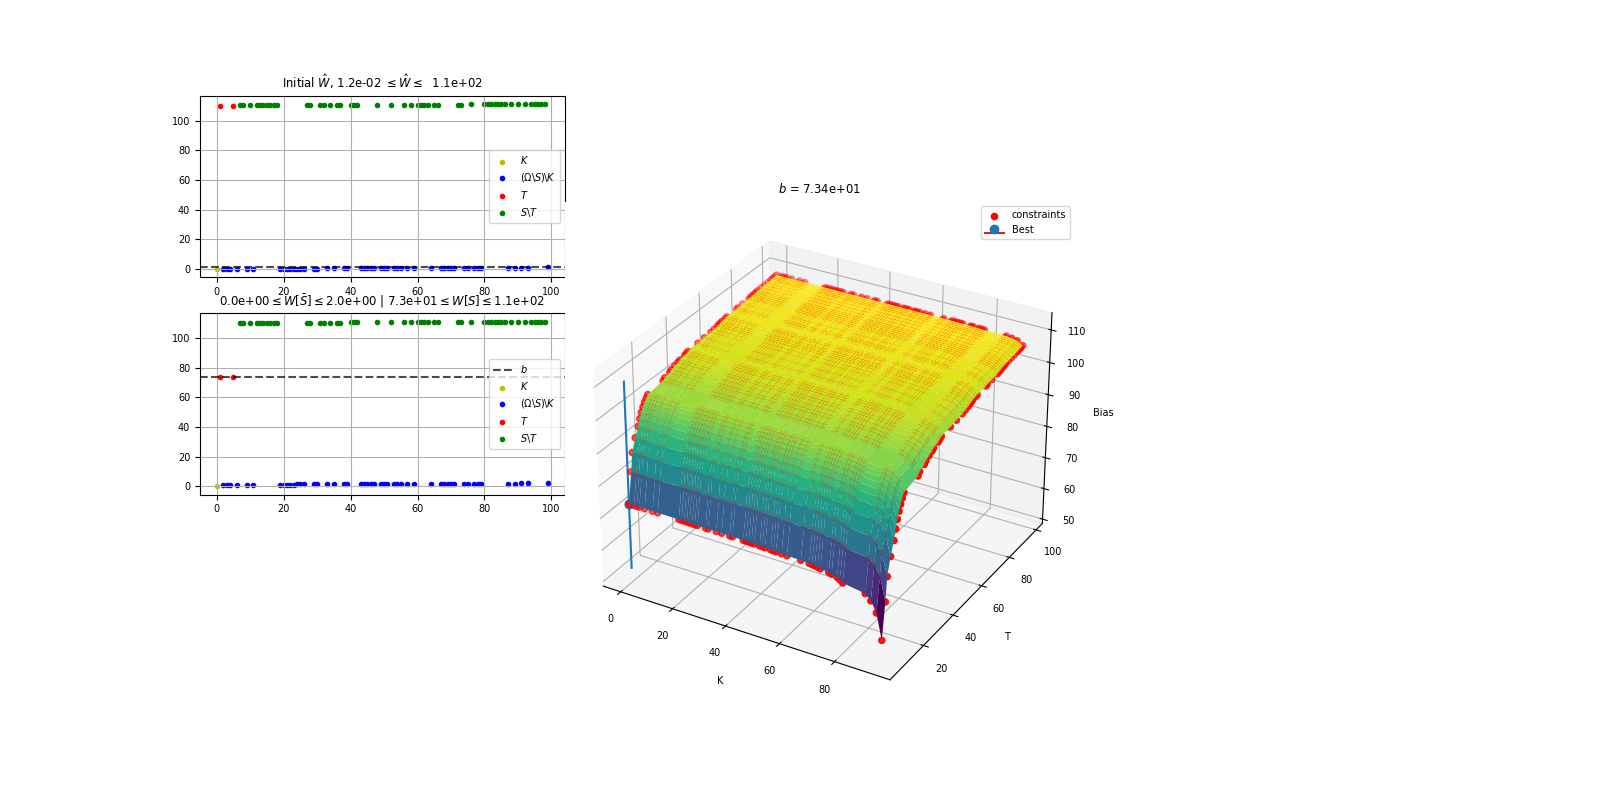

In [143]:
cur_Ks = all_Ks[:-1]
cur_Ts = all_Ts
cur_df = ok_df[ok_df["idx_K"] < all_Ks[-1]]

best_T = row["T"]
best_K = row["K"]

mplot = MultiPlot(3, 3, figsize=(4*4, 4*2))

# Init W ######################################

ax = mplot.add_subplot((1, 1))
ax.axhline(y=b, color="black", alpha=.7, ls="--")

plot_sets_on_ax(W=W, K=best_K, T=best_T, S=S, ax=ax)

ax.set_title(rf"Initial $\hat W$, {W.min():.1e} $\leq \hat W \leq $  {W.max():.1e}")
ax.legend()


# Proj W ######################################
Wbest = row["W"]
bbest = row["b"]

ax = mplot.add_subplot((2, 1))
ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")

ax.axhline(bbest, c="k", alpha=.7, ls="--", label=r"$b$")
plot_sets_on_ax(W=Wbest, K=best_K, T=best_T, S=S, ax=ax)
ax.legend()

# Bias wrt T, K ######################################
ax = mplot.fig.add_subplot(6, 2, (3, 12), projection="3d")
bias_table = pd.pivot_table(df, index="idx_T", columns="idx_K", values="b")

ax.scatter3D(cur_df["idx_K"].values, cur_df["idx_T"].values, cur_df["b"].values, color="red", label="constraints")
ax.plot_surface(*np.meshgrid(all_Ks[:-1], all_Ts), bias_table.values[:, :-1], cmap="viridis")
ax.set_xlabel("K")
ax.set_ylabel("T")
ax.set_zlabel("Bias")
ax.set_title(rf"$b$ = {row['b']:.2e}")
ax.stem([row["idx_K"]], [row["idx_T"]], [row["b"]], bottom=ax.get_zlim()[1], label="Best")
ax.stem([row["idx_K"]], [row["idx_T"]], [row["b"]], bottom=ax.get_zlim()[0], )
ax.legend()

In [112]:
cur_df.columns

Index(['b', 'lambda0', 'loss', 'lambdat', 'lambdak', 'W', 'conds_init_left',
       'conds_init_right', 'conds_init_positive', 'margins_init_left',
       'margins_init_right', 'margins_init_positive', 'conds_proj_left',
       'conds_proj_right', 'conds_proj_positive', 'margins_proj_left',
       'margins_proj_right', 'margins_proj_positive', 'lagrangian_cond',
       'idx_T', 'T', 'idx_K', 'K', 'proj', 'lambdat_neg', 'lambdak_neg',
       'lambdat_min', 'lambdak_min'],
      dtype='object')

In [146]:

failed = []
for row in tqdm(cur_df[["card_K", "card_T"]].values):
    next_k = row[0] + 1
    next_t = row[1] + 1

    if next_k > cur_df["card_K"].max():
        continue

    if next_t > cur_df["card_T"].max():
        continue

    if not (np.array([next_k, row[1]]) == cur_df[["card_K", "card_T"]].values).prod(1).any():
        failed.append(row)
    
    if not (np.array([row[0], next_t]) == cur_df[["card_K", "card_T"]].values).prod(1).any():
        failed.append(row)
    
    if not (np.array([next_k, next_t]) == cur_df[["card_K", "card_T"]].values).prod(1).any():
        failed.append(row)

print(failed)

  0%|          | 0/2401 [00:00<?, ?it/s]

[]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

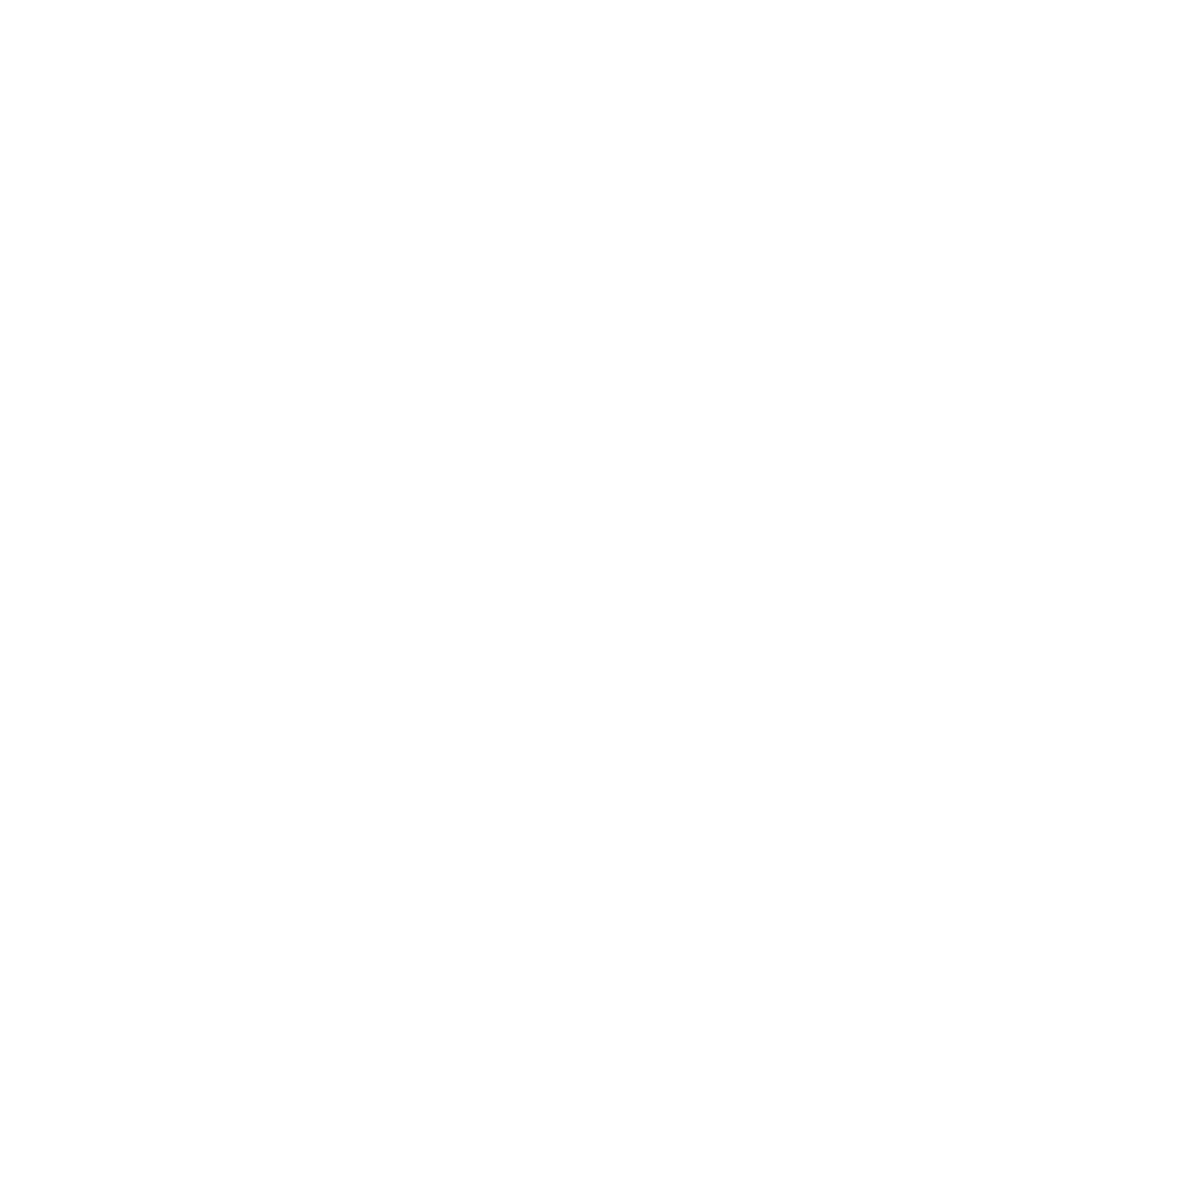

In [145]:
cur_Ks = all_Ks[:-1]
cur_Ts = all_Ts
cur_df = ok_df[ok_df["idx_K"] < all_Ks[-1]]


def plot_3d(ax, col):
    col_table = pd.pivot_table(df, index="idx_T", columns="idx_K", values=col)
    ax.scatter3D(cur_df["idx_K"].values, cur_df["idx_T"].values, cur_df[col].values, color="red", label="constraints")
    ax.plot_surface(*np.meshgrid(all_Ks[:-1], all_Ts), col_table.values[:, :-1], cmap="viridis")
    ax.set_xlabel("K")
    ax.set_ylabel("T")
    # ax.set_zlabel(col)
    ax.set_title(rf"${col}$ = {row[col]:.2e}")
    ax.stem([row["idx_K"]], [row["idx_T"]], [row[col]], bottom=ax.get_zlim()[1], label="Best")
    ax.stem([row["idx_K"]], [row["idx_T"]], [row[col]], bottom=ax.get_zlim()[0], )

mplot = MultiPlot(2, 3, figsize=(4*3, 4*3))
mplot.fig.suptitle(f"K={row['idx_K']} T={row['idx_T']}")

# Loss wrt T ######################################
ax = mplot.add_subplot((2, 3), projection="3d")
plot_3d(ax, "loss")

# Number of negative lagrangians lambda_k wrt T ######################################
ax = mplot.add_subplot((1, 1), projection="3d")
plot_3d(ax, "lambdak_neg")

# Number of negative lagrangians lambda_t wrt T ######################################
ax = mplot.add_subplot((1, 2), projection="3d")
plot_3d(ax, "lambdat_neg")


# Lambda 0 wrt T ######################################
ax = mplot.add_subplot((1, 3), projection="3d")
plot_3d(ax, "lambda0")

# Min lambda_k wrt T ######################################
ax = mplot.add_subplot((2, 1), projection="3d")
plot_3d(ax, "lambdak_min")

# Min lambda_t wrt T ######################################
ax = mplot.add_subplot((2, 2), projection="3d")
plot_3d(ax, "lambdat_min")

# # Constraint right margin wrt T ######################################
# ax = mplot.add_subplot((2, 2), projection="3d")
# plot_3d(ax, "margins_proj_right")

# # Constraint left margin wrt T ######################################
# ax = mplot.add_subplot((2, 3), projection="3d")
# plot_3d(ax, "margins_proj_left",)





In [ ]:
all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T).projection_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df2 = pd.DataFrame(all_res, )
df2.index = df2["idx_T"]
df2["lambdat_neg"] = df2["lambdat"].apply(lambda x: (x < 1e-5).sum())
df2["Ws_min"] = df2["W"].apply(lambda x: x[S].min())

good_idx = np.where(
    df2["right_cond_proj"] & df2["lagrangian_cond"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    # best_idx = df2.index[good_idx[0][0]]
    best_idx = df2["loss"].iloc[good_idx].idxmin()

    print("Constraint left", df2.loc[best_idx, "left_cond_proj"], "Margin left", df2.loc[best_idx, "left_margin_proj"])
    print("constraint right", df2.loc[best_idx, "right_cond_proj"], "Margin right", df2.loc[best_idx, "right_margin_proj"])
print("Best idx", best_idx)




Possibles Ts: 1
Constraint left False Margin left -57.23062304967187
constraint right True Margin right 0.0
Best idx 274


In [11]:
df2.loc[df2["right_cond_proj"] & df2["left_cond_proj"], ["loss"]]

NameError: name 'df2' is not defined

NameError: name 'df2' is not defined

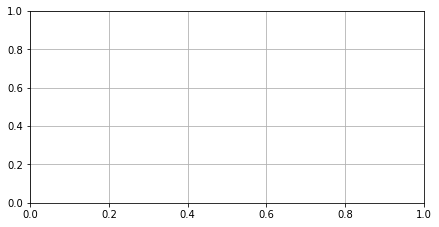

In [12]:


# mplot = plt.figure(figsize=(6*4, 6*2))
mplot = MultiPlot(3, 3, figsize=(6*4, 6*2))

# Loss wrt T
ax = mplot.add_subplot((1, 3))
ax.plot(all_Ts, df2.loss)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$L$ = {df2.loc[best_idx, 'loss']:.2e}")
else:
    ax.set_title(rf"$L$")

# Number of negative lagrangians lambda_t wrt T
ax = mplot.add_subplot((2, 3))
ax.plot(all_Ts, df2.lambdat_neg,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title(r"#$\lambda_t$ negative")


# Constraint right margin wrt T
ax = mplot.add_subplot((3, 3))
ax.plot(all_Ts, df2["right_margin_proj"],)
# ax.plot(all_Ts, df2["Ws_min"] - df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
# ax.set_title(r"$\min_S W - b$")
ax.set_title("Right margin")

# Constraint left margin wrt T
ax = mplot.add_subplot((3, 2))
ax.plot(all_Ts, df2["left_margin_proj"],)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title("left margin")
# ax.axhline(y=-epsilon, color="red", alpha=.3, ls="--")
# ax.axhline(y=+epsilon, color="red", alpha=.3, ls="--")

# b wrt T
ax = mplot.add_subplot((1, 2))
ax.plot(all_Ts, df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$b_p$ = {df2.loc[best_idx, 'b']:.2e}")
else:
    ax.set_title(rf"$b_p$")


legend_colors = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4)]
legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


ax = mplot.add_subplot((1, 1))
# ax = mplot.add_subplot((1, 1,), nrow=2)
ax.plot(Sbar_idx, W[~S], c="b", label=r"$\Omega \backslash S$")
if best_idx is not None:
    best_T = df2.loc[best_idx, "T"]
    T_idx = np.where(best_T)[0]
    ax.plot(T_idx, W[best_T], c="r", label=r"$T$")
    ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    
    Tbar_idx = np.where(S & ~best_T)[0]
    ax.plot(Tbar_idx, W[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")
ax.set_title(rf"Initial W, {W.min():.1e} $\leq W \leq $  {W.max():.1e}")
ax.legend()

if best_idx is not None:
    Wbest = df2.loc[best_idx, "W"]

    # ax = mplot.add_subplot((2, 1), nrow=2,)
    ax = mplot.add_subplot((2, 1))
    # ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
    
    ax.plot(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.plot(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--", label=r"Init $S \backslash T$")

    ax.plot(T_idx, Wbest[best_T], c="r", label=r"$T$")
    ax.plot(T_idx, W[best_T], c="r", alpha=.6, ls="--", label=r"Init $T$")
    # ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.legend()

    ax = mplot.add_subplot((3, 1))
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")
    ax.legend()
    # ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")




In [194]:
proj = Projection(Wini=W, bini=b, S=S).projection_left()

for k in ["left_cond_proj", "right_cond_proj", "left_margin_proj", "right_margin_proj"]:
    print(f"{k}: {proj.summary[k]}")
# {k: v for k, v in proj.summary.items() if k not in ["W"]}

left_cond_proj: True
right_cond_proj: False
left_margin_proj: -4.3298697960381105e-14
right_margin_proj: -0.9488382540925584


# Iterative Only Weights

In [5]:
from dataclasses import dataclass

@dataclass
class IterativeProjectionWeights:
    Wini: np.ndarray
    S: np.ndarray
    operation: str = "dilation"

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        self.Wvar = cp.Variable(self.Wini.shape)
        self.bvar = cp.Variable(1)

        if self.operation == "dilation":
            self.constraints = self.dilation_constraints(self.Wvar, self.S)
        elif self.operation == "erosion":
            self.constraints = self.erosion_constraints(self.Wvar, self.S)
        else:
            raise ValueError("operation must be dilation or erosion")

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - self.Wini))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()

        return self

    def dilation_constraints(self, Wvar: cp.Variable, S: np.ndarray):
        self.constraintsT = [cp.sum(Wvar[~S]) <= Wvar[S]]
        self.constraintsK = [Wvar >= 0]
        return self.constraintsT + self.constraintsK

    def erosion_constraints(self, Wvar: cp.Variable, S: np.ndarray):
        self.constraintsT = [cp.sum(Wvar[S]) >= cp.sum(Wvar) - Wvar[S]]
        self.constraintsK = [Wvar >= 0]
        return self.constraintsT + self.constraintsK

    @property
    def value(self):
        return self.prob.value

    @property
    def W(self):
        return self.Wvar.value

    @property
    def K(self):
        return np.isclose(self.W, 0) & ~self.S

    @property
    def Kbar(self):
        return ~self.S & ~self.K
    
    @property
    def T(self):
        return np.isclose(self.W, self.W[~self.S].sum()) & self.S
    
    @property
    def lambdat(self):
        return np.array([constraint.dual_value for constraint in self.constraintsT])
    
    @property
    def lambdak(self):
        return np.array([constraint.dual_value for constraint in self.constraintsK])

    @property
    def loss(self):
        return self.prob.value
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"Loss={self.loss:.4e} "
            f"Kbar: {self.Kbar.sum()} K: {self.K.sum()} T: {self.T.sum()}"
            ")"
        )




In [6]:
Wini = np.unique(np.random.rand(100))
N = len(Wini)
S = np.random.randint(0, 2, N).astype(bool)


proj = IterativeProjectionWeights(Wini=Wini, S=S).solve()

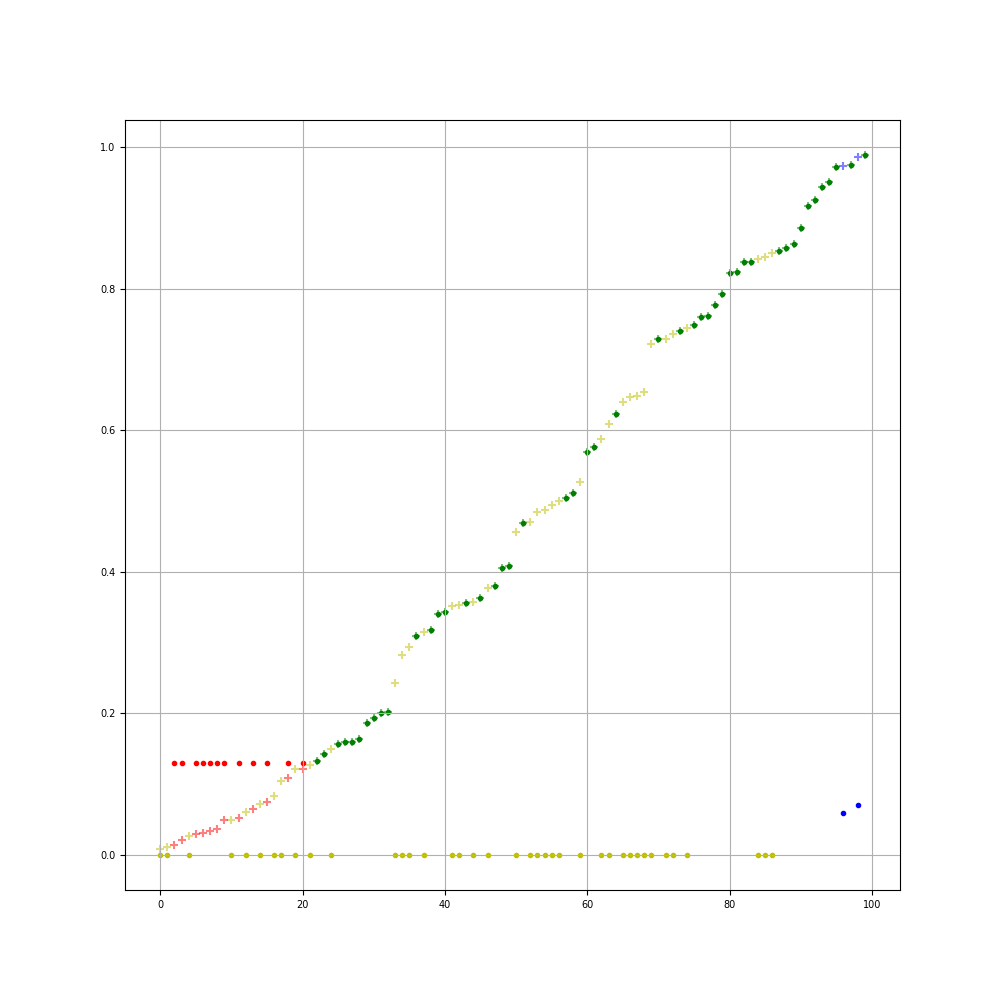

In [82]:
mplot = MultiPlot(1, 1, figsize=(10, 10))

ax = mplot.add_subplot((1, 1))
plot_sets_on_ax(W=Wini, K=proj.K, T=proj.T, S=proj.S, ax=ax, marker="+", alpha=.5)

# ax = mplot.add_subplot((2, 1))
plot_sets_on_ax(W=proj.W, K=proj.K, T=proj.T, S=proj.S, ax=ax, marker=".")


In [54]:
def system_weights(Kbar, K, T):
    A = np.zeros((Kbar + K + T, Kbar + K + T))

    A[:Kbar, :Kbar] = np.eye(Kbar)
    A[:Kbar, -T:] = 1

    A[Kbar:Kbar + K, Kbar:Kbar + K] = -np.eye(K)
    A[Kbar:Kbar + K, -T:] = 1
    
    A[-T:, :Kbar] = 1
    A[-T:, -T:] = -np.eye(T)

    return A

def system_weights_inv(Kbar, K, T):
    Ainv = np.zeros((Kbar + K + T, Kbar + K + T))

    c = 1 / (Kbar * T + 1)
    a = T * c
    d = Kbar * c

    Ainv[:Kbar, :Kbar] = np.eye(Kbar) - a
    Ainv[:Kbar, -T:] = c

    Ainv[Kbar:Kbar + K, :K] = a
    Ainv[Kbar:Kbar + K, Kbar: Kbar + K] = - np.eye(K)
    Ainv[Kbar:Kbar + K, -T:] = -c

    Ainv[-T:, :Kbar] = c
    Ainv[-T:, -T:] = - np.eye(T) + d

    return Ainv


In [57]:
Kbar, K, T = 2, 3, 4

A = system_weights(Kbar, K, T)
Ainv = np.linalg.inv(A)
Ainv2 = system_weights_inv(Kbar, K, T)
print(np.array2string(A, precision=2, suppress_small=True))
print(np.array2string(Ainv, precision=2, suppress_small=True))
# print(np.array2string(Ainv2, precision=2, suppress_small=True))
print(np.allclose(Ainv, Ainv2))

a = 1 - Ainv[0, 0]
c = Ainv[0, -1]
d = Ainv[-1, -1] + 1


[[ 1.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  1.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0. -1. -0. -0.  1.  1.  1.  1.]
 [ 0.  0. -0. -1. -0.  1.  1.  1.  1.]
 [ 0.  0. -0. -0. -1.  1.  1.  1.  1.]
 [ 1.  1.  0.  0.  0. -1. -0. -0. -0.]
 [ 1.  1.  0.  0.  0. -0. -1. -0. -0.]
 [ 1.  1.  0.  0.  0. -0. -0. -1. -0.]
 [ 1.  1.  0.  0.  0. -0. -0. -0. -1.]]
[[ 0.56 -0.44  0.    0.    0.    0.11  0.11  0.11  0.11]
 [-0.44  0.56  0.    0.    0.    0.11  0.11  0.11  0.11]
 [ 0.44  0.44 -1.   -0.   -0.   -0.11 -0.11 -0.11 -0.11]
 [ 0.44  0.44 -0.   -1.   -0.   -0.11 -0.11 -0.11 -0.11]
 [ 0.44  0.44 -0.   -0.   -1.   -0.11 -0.11 -0.11 -0.11]
 [ 0.11  0.11 -0.   -0.   -0.   -0.78  0.22  0.22  0.22]
 [ 0.11  0.11 -0.   -0.   -0.    0.22 -0.78  0.22  0.22]
 [ 0.11  0.11 -0.   -0.   -0.    0.22  0.22 -0.78  0.22]
 [ 0.11  0.11 -0.   -0.   -0.    0.22  0.22  0.22 -0.78]]
True


In [33]:
X.shape

(100,)

In [58]:
X = np.concatenate([proj.W[proj.Kbar], proj.lambdak[proj.lambdak != 0], proj.lambdat[proj.lambdat != 0]])
Y = np.concatenate([Wini[proj.Kbar], Wini[proj.K], Wini[proj.T]])

A = system_weights(proj.Kbar.sum(), proj.K.sum(), proj.T.sum())
Ainv = system_weights_inv(proj.Kbar.sum(), proj.K.sum(), proj.T.sum())

print(np.abs(A @ X - Y).sum())
print(np.abs(Ainv @ Y - X).sum())

1.2741543931049648e-13
9.164544123585472e-15


In [71]:
denom = proj.Kbar.sum() * proj.T.sum() + 1
print(np.allclose(proj.W[proj.Kbar], Wini[proj.Kbar] + 1 / denom * (Wini[proj.T].sum() - proj.T.sum() * Wini[proj.Kbar].sum())))
print(np.allclose(proj.lambdak[proj.lambdak != 0], -Wini[proj.K] + 1 / denom * (proj.T.sum() * Wini[proj.Kbar].sum() - Wini[proj.T].sum())))
print(np.allclose(proj.lambdat[proj.lambdat != 0], -Wini[proj.T] + 1 / denom * (Wini[proj.Kbar].sum() + proj.Kbar.sum() * Wini[proj.T].sum())))

True
True
True


In [72]:
Kbar = proj.Kbar
K = proj.K
T = proj.T


In [79]:
1 / T.sum() * Wini[T].sum()

0.053184688600983354

In [77]:
Wini[Kbar].sum()

1.9601389954231896